In [ ]:
import os, glob, math, textwrap, gc
import joblib, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from scipy.stats import zscore
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from scipy.stats import ks_2samp
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GroupKFold
import json
from collections import Counter
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  HalvingGridSearchCV

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

BASE_DIR = Path(".").resolve()
TRAIN_DIR = BASE_DIR / "train"
SUPP_CSV = BASE_DIR / "supplementary_data.csv"
CACHE_DIR = BASE_DIR / "_cache"
MODELS_DIR = BASE_DIR / "models"
CACHE_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("TRAIN_DIR exists:", TRAIN_DIR.exists())
print("SUPP exists:", SUPP_CSV.exists())
print("CACHE_DIR:", CACHE_DIR)


BASE_DIR: C:\Users\kearn\BigDataBowl
TRAIN_DIR exists: True
SUPP exists: True
CACHE_DIR: C:\Users\kearn\BigDataBowl\_cache


## Modeling Expected Seperation

### Play filtering and data loading

In [2]:
# Defender-Focused Expected Separation Over Expected 
# NFL Big Data Bowl 2026

INPUT_USE_COLS = [
    "game_id","play_id","player_to_predict","nfl_id","frame_id","play_direction",
    "absolute_yardline_number","player_name","player_height","player_weight","player_birth_date",
    "player_position","player_side","player_role",
    "x","y","s","a","dir","o","num_frames_output","ball_land_x","ball_land_y"
]
OUTPUT_USE_COLS = ["game_id","play_id","nfl_id","frame_id","x","y"]
SUPP_USE_COLS = [
    "game_id","season","week","play_id","quarter","game_clock","down","yards_to_go",
    "yardline_side","yardline_number","play_nullified_by_penalty","pass_result","pass_length",
    "offense_formation","receiver_alignment","route_of_targeted_receiver",
    "play_action","dropback_type","dropback_distance","pass_location_type",
    "defenders_in_the_box","team_coverage_man_zone","team_coverage_type",
    "yards_gained","expected_points_added","possession_team","defensive_team"
]

DTYPES_INPUT = {
    "game_id":"int64","play_id":"int32","player_to_predict":"bool","nfl_id":"int32","frame_id":"int16",
    "play_direction":"category","absolute_yardline_number":"float32",
    "player_name":"object","player_height":"object","player_weight":"float32","player_birth_date":"object",
    "player_position":"category","player_side":"category","player_role":"category",
    "x":"float32","y":"float32","s":"float32","a":"float32","dir":"float32","o":"float32",
    "num_frames_output":"int16","ball_land_x":"float32","ball_land_y":"float32"
}
DTYPES_OUTPUT = {"game_id":"int64","play_id":"int32","nfl_id":"int32","frame_id":"int16","x":"float32","y":"float32"}
DTYPES_SUPP = {
    "game_id":"int64","season":"int16","week":"int8","play_id":"int32","quarter":"int8",
    "down":"float32","yards_to_go":"float32","yardline_number":"float32",
    "pass_length":"float32","dropback_distance":"float32","defenders_in_the_box":"float32",
    "yards_gained":"float32","expected_points_added":"float32"
}
READ_KW = dict(encoding="utf-8", low_memory=False)

print("✓ Configurations loaded")


# Data loading functions
def _week_str(w): 
    return f"{int(w):02d}"

def cache_path(kind: str, week: int) -> Path: 
    return CACHE_DIR / f"{kind}_2023_w{_week_str(week)}.parquet"

def load_input_week(week: int, use_cache=True) -> pd.DataFrame:
    p = cache_path("input", week)
    if use_cache and p.exists(): 
        return pd.read_parquet(p)
    df = pd.read_csv(TRAIN_DIR / f"input_2023_w{_week_str(week)}.csv",
                     usecols=INPUT_USE_COLS, dtype=DTYPES_INPUT, **READ_KW)
    if use_cache: 
        df.to_parquet(p, index=False)
    return df

def load_output_week(week: int, use_cache=True) -> pd.DataFrame:
    p = cache_path("output", week)
    if use_cache and p.exists(): 
        return pd.read_parquet(p)
    df = pd.read_csv(TRAIN_DIR / f"output_2023_w{_week_str(week)}.csv",
                     usecols=OUTPUT_USE_COLS, dtype=DTYPES_OUTPUT, **READ_KW)
    if use_cache: 
        df.to_parquet(p, index=False)
    return df

def load_supplementary(use_cache=True) -> pd.DataFrame:
    p = CACHE_DIR / "supplementary.parquet"
    if use_cache and p.exists(): 
        return pd.read_parquet(p)
    df = pd.read_csv(SUPP_CSV, usecols=SUPP_USE_COLS, dtype=DTYPES_SUPP, **READ_KW)
    for c in ["possession_team","defensive_team","yardline_side","pass_result","offense_formation",
              "receiver_alignment","route_of_targeted_receiver","play_action","dropback_type",
              "pass_location_type","team_coverage_man_zone","team_coverage_type"]:
        if c in df.columns: 
            df[c] = df[c].astype("category")
    if use_cache: 
        df.to_parquet(p, index=False)
    return df

print("Loading supplementary data...")
supp_df = load_supplementary()
print(f"✓ Loaded {len(supp_df):,} plays")

# Geometry helpers
def wrap_deg(d): 
    """Wrap degrees to [-180, 180]"""
    if pd.isna(d): return 0.0
    d = ((d + 180) % 360) - 180
    return d

def ang_to_vec_sin_cos(deg):
    """Convert angle to sin/cos components"""
    rad = np.deg2rad(deg)
    return np.sin(rad), np.cos(rad)

def angle_between(a_deg, b_deg):
    """Smallest difference between two headings"""
    a = np.deg2rad(a_deg)
    b = np.deg2rad(b_deg)
    d = np.rad2deg(np.arctan2(np.sin(a-b), np.cos(a-b)))
    return d

def dist(ax, ay, bx, by):
    """Euclidean distance"""
    return float(np.hypot((ax - bx), (ay - by)))

print("✓ Geometry functions ready")

def normalize_by_direction(df):
    """
    Normalize all plays to move left→right (offensive gain direction).
    If play_direction=='left', mirror x-coordinates and flip angles by 180°.
    """
    df = df.copy()
    if 'play_direction' not in df.columns: 
        return df
    
    mask_left = (df['play_direction'].astype(str).str.lower() == 'left')
    
    # Mirror x-coordinate 
    df.loc[mask_left, 'x'] = 120.0 - df.loc[mask_left, 'x']
    df.loc[mask_left, 'ball_land_x'] = 120.0 - df.loc[mask_left, 'ball_land_x']
    
    # Flip direction/orientation by 180 to maintain moving right
    for c in ['dir', 'o']:
        if c in df.columns:
            df.loc[mask_left, c] = (df.loc[mask_left, c] + 180.0) % 360.0
    
    return df

print("✓ Direction normalization ready")
#Route normalization
ROUTE_ALIAS = {"WHEEL": "GO"}

def canonical_route(x):
    if pd.isna(x): 
        return "UNKNOWN"
    s = str(x).strip().upper()
    return ROUTE_ALIAS.get(s, s)

# Feature Extraction (Defender-Centric)

def extract_defender_rows_for_play(game_id, play_id, input_df, output_df, supp_row, arrival_radius=15.0):
    """
    Build rows for every defender within 'arrival_radius' yards of targeted receiver at arrival.
    
    Features computed from RELEASE frame ONLY (no leakage).
    Target is actual separation(defender→receiver) at ARRIVAL.
    
    Returns list of dicts, one per qualifying defender.
    """
    # Filter to this play
    pin = input_df[(input_df.game_id == game_id) & (input_df.play_id == play_id)].copy()
    pout = output_df[(output_df.game_id == game_id) & (output_df.play_id == play_id)].copy()
    
    if len(pin) == 0 or len(pout) == 0: 
        return []
    
    # Normalize direction (all plays moving right)
    pin = normalize_by_direction(pin)
    pout = normalize_by_direction(pout)
    
    last_in_frame = pin['frame_id'].max()
    last_out_frame = pout['frame_id'].max()
    
    # Targeted receiver at release
    rec_rel = pin[(pin['frame_id'] == last_in_frame) & (pin['player_role'] == 'Targeted Receiver')]
    if len(rec_rel) == 0: 
        return []
    rec_rel = rec_rel.iloc[0]
    EXCLUDE_POSITIONS = {"QB", "T", "K", "P"}  # expand if your data uses other labels
    rec_pos = str(rec_rel.get("player_position", "")).upper()
    if rec_pos in EXCLUDE_POSITIONS:
        return []

    
    rec_id = int(rec_rel['nfl_id'])
    
    # Receiver at arrival
    rec_arr = pout[(pout['frame_id'] == last_out_frame) & (pout['nfl_id'] == rec_id)]
    if len(rec_arr) == 0: 
        return []
    rec_arr = rec_arr.iloc[0]
    
    # Time in air
    frames_out = float(rec_rel['num_frames_output'])
    if frames_out <= 0: 
        return []
    time_in_air = frames_out / 10.0
    
    # Defenders at release
    defs_rel = pin[(pin['frame_id'] == last_in_frame) & (pin['player_side'] == 'Defense')].copy()
    if len(defs_rel) == 0: 
        return []
    
    # Defenders at arrival (same IDs from release)
    defs_arr = pout[(pout['frame_id'] == last_out_frame) & (pout['nfl_id'].isin(defs_rel['nfl_id']))].copy()
    if len(defs_arr) == 0: 
        return []
    
    # Identify defenders within radius at arrival
    
    defs_arr['dist_to_rec_arrival'] = np.hypot(defs_arr['x'] - rec_arr['x'], defs_arr['y'] - rec_arr['y'])
    nearby = defs_arr[defs_arr['dist_to_rec_arrival'] <= arrival_radius].copy()
    if len(nearby) == 0:
        return []

    #nearby = nearby.nsmallest(3, 'dist_to_rec_arrival')

    
    # Receiver features at release
    rec_dir_rel = float(rec_rel['dir']) if pd.notna(rec_rel['dir']) else 0.0
    rec_o_rel = float(rec_rel['o']) if pd.notna(rec_rel['o']) else 0.0
    rec_s_rel = float(rec_rel['s']) if pd.notna(rec_rel['s']) else 0.0
    rec_a_rel = float(rec_rel['a']) if pd.notna(rec_rel['a']) else 0.0
    
    # Ball landing location
    bx, by = float(rec_rel['ball_land_x']), float(rec_rel['ball_land_y'])
    rec_to_ball_dist = dist(rec_rel['x'], rec_rel['y'], bx, by)
    ang_rec_to_ball = np.degrees(np.arctan2(by - rec_rel['y'], bx - rec_rel['x']))
    
    # Global minimum separation at release (tightest coverage overall)
    defs_rel_tmp = defs_rel.copy()
    defs_rel_tmp['d_release'] = np.hypot(defs_rel_tmp['x'] - rec_rel['x'], defs_rel_tmp['y'] - rec_rel['y'])
    global_min_sep_release = float(defs_rel_tmp['d_release'].min())
    
    rows = []
    
    # Build row for each qualifying defender
    for _, arr_d in nearby.iterrows():
        did = int(arr_d['nfl_id'])
        
        # Defender at release
        d_rel = defs_rel[defs_rel['nfl_id'] == did]
        if len(d_rel) == 0: 
            continue  # Defender not tracked at release
        d_rel = d_rel.iloc[0]
        
        # TARGET: actual separation at arrival
        sep_arrival = float(arr_d['dist_to_rec_arrival'])
        
        # Defender kinematics at release
        d_s = float(d_rel['s']) if pd.notna(d_rel['s']) else 0.0
        d_a = float(d_rel['a']) if pd.notna(d_rel['a']) else 0.0
        d_dir = float(d_rel['dir']) if pd.notna(d_rel['dir']) else 0.0
        d_o = float(d_rel['o']) if pd.notna(d_rel['o']) else 0.0
        
        # Distances at release
        d2r_rel = dist(d_rel['x'], d_rel['y'], rec_rel['x'], rec_rel['y'])
        d2b_rel = dist(d_rel['x'], d_rel['y'], bx, by)
        
        # Angles at release
        ang_d_to_rec = np.degrees(np.arctan2(rec_rel['y'] - d_rel['y'], rec_rel['x'] - d_rel['x']))
        ang_d_to_ball = np.degrees(np.arctan2(by - d_rel['y'], bx - d_rel['x']))
        
        # Turn angles (how much defender needs to turn from current orientation)
        turn_to_rec = angle_between(d_o, ang_d_to_rec)
        turn_to_ball = angle_between(d_o, ang_d_to_ball)
        
        # Closing speed components (project velocity onto pursuit direction)
        d_dir_rad = np.deg2rad(d_dir)
        vec_vx, vec_vy = np.cos(d_dir_rad), np.sin(d_dir_rad)
        
        EPS = 1e-12  # small number to avoid division-by-zero

        # Unit vector toward receiver
        urx = float(rec_rel["x"]) - float(d_rel["x"])
        ury = float(rec_rel["y"]) - float(d_rel["y"])
        ur_norm = max(math.hypot(urx, ury), EPS)
        urx /= ur_norm
        ury /= ur_norm

        # Unit vector toward ball
        ubx = float(bx) - float(d_rel["x"])
        uby = float(by) - float(d_rel["y"])
        ub_norm = max(math.hypot(ubx, uby), EPS)
        ubx /= ub_norm
        uby /= ub_norm

        # Dot product = closing speed component
        closing_to_rec  = d_s * (vec_vx * urx + vec_vy * ury)
        closing_to_ball = d_s * (vec_vx * ubx + vec_vy * uby)

        # Receiver movement relative to defender
        r_dir_rad = np.deg2rad(rec_dir_rel)
        rvx, rvy  = np.cos(r_dir_rad), np.sin(r_dir_rad)
        r_to_d_x  = float(d_rel["x"]) - float(rec_rel["x"])
        r_to_d_y  = float(d_rel["y"]) - float(rec_rel["y"])
        r_to_d_norm = max(math.hypot(r_to_d_x, r_to_d_y), EPS)
        r_to_d_x /= r_to_d_norm
        r_to_d_y /= r_to_d_norm
        rec_toward_def = rec_s_rel * (rvx * r_to_d_x + rvy * r_to_d_y)

        this_sep_release = float(d2r_rel)
        
        # Build feature row
        rows.append({
            # Identifiers
            "game_id": game_id,
            "play_id": play_id,
            "week": supp_row.get("week"),
            "receiverId": int(rec_id),
            "defenderId": int(did),
            "passResult": supp_row.get("pass_result"),
            
            # Route & Coverage
            "route": canonical_route(supp_row.get("route_of_targeted_receiver")),
            "coverage_man_zone": (str(supp_row.get("team_coverage_man_zone")) if pd.notna(supp_row.get("team_coverage_man_zone")) else "UNKNOWN").upper(),
            "coverage_type": (str(supp_row.get("team_coverage_type")) if pd.notna(supp_row.get("team_coverage_type")) else "UNKNOWN").upper(),
            
            # Game situation
            "down": float(supp_row.get("down")) if pd.notna(supp_row.get("down")) else 1.0,
            "yards_to_go": float(supp_row.get("yards_to_go")) if pd.notna(supp_row.get("yards_to_go")) else 10.0,
            "yardline_number": float(supp_row.get("yardline_number")) if pd.notna(supp_row.get("yardline_number")) else 50.0,
            "dropback_distance": float(supp_row.get("dropback_distance")) if pd.notna(supp_row.get("dropback_distance")) else 0.0,
            "pass_location_type": (str(supp_row.get("pass_location_type")) if pd.notna(supp_row.get("pass_location_type")) else "UNKNOWN").upper(),
            
            # Ball trajectory
            "time_in_air": time_in_air,
            "ball_land_x": bx,
            "ball_land_y": by,
            "rec_to_ball_dist": rec_to_ball_dist,
            
            # Receiver (release)
            "rec_x_release": float(rec_rel['x']),
            "rec_y_release": float(rec_rel['y']),
            "rec_speed_release": rec_s_rel,
            "rec_accel_release": rec_a_rel,
            "rec_dir_release": rec_dir_rel,
            "rec_o_release": rec_o_rel,
            "receiverName": str(rec_rel.get("player_name", "")),
            "defenderName": str(d_rel.get("player_name", "")),
            # Defender (release)
            "def_x_release": float(d_rel['x']),
            "def_y_release": float(d_rel['y']),
            "def_speed_release": d_s,
            "def_accel_release": d_a,
            "def_dir_release": d_dir,
            "def_o_release": d_o,
            
            # Pairwise geometry (release)
            "def_to_rec_dist_release": d2r_rel,
            "def_to_ball_dist_release": d2b_rel,
            "def_to_rec_angle": ang_d_to_rec,
            "def_to_ball_angle": ang_d_to_ball,
            "def_turn_to_rec": turn_to_rec,
            "def_turn_to_ball": turn_to_ball,
            "def_closing_speed_to_rec": closing_to_rec,
            "def_closing_speed_to_ball": closing_to_ball,
            "rec_toward_def_speed": rec_toward_def,
            "rec_to_ball_angle": ang_rec_to_ball,
            "global_min_sep_at_release": global_min_sep_release,
            
            # TARGET
            "sep_arrival_def": sep_arrival,
            "sep_release_def": this_sep_release
        })
    
    return rows

print("✓ Feature extraction function ready")


print("\n" + "="*70)
print("EXTRACTING DEFENDER-CENTRIC ROWS")
print("="*70)

WEEKS_TO_PROCESS = list(range(1, 19))  

rows = []

for w in WEEKS_TO_PROCESS:
    print(f"\nWeek {w}:")
    pin = load_input_week(w, use_cache=True)
    pout = load_output_week(w, use_cache=True)
    plays = supp_df[supp_df['week'] == w]
    
    for i, (_, prow) in enumerate(plays.iterrows(), 1):
        if i % 200 == 0:
            print(f"  {i}/{len(plays)} plays...")
        
        rows.extend(extract_defender_rows_for_play(
            int(prow['game_id']),
            int(prow['play_id']),
            pin, pout, prow,
            arrival_radius=15.0
        ))
    
    print(f"  ✓ Total rows so far: {len(rows):,}")
    del pin, pout
    gc.collect()

df = pd.DataFrame(rows)
print(f"\n{'='*70}")
print(f"EXTRACTION COMPLETE: {len(df):,} defender-rows")
print(f"{'='*70}")

df.to_csv("defender_rows_raw.csv", index=False)
print("✓ Saved: defender_rows_raw.csv")

✓ Configurations loaded
Loading supplementary data...
✓ Loaded 18,009 plays
✓ Geometry functions ready
✓ Direction normalization ready
✓ Feature extraction function ready

EXTRACTING DEFENDER-CENTRIC ROWS

Week 1:
  200/819 plays...
  400/819 plays...
  600/819 plays...
  800/819 plays...
  ✓ Total rows so far: 1,740

Week 2:
  200/850 plays...
  400/850 plays...
  600/850 plays...
  800/850 plays...
  ✓ Total rows so far: 3,512

Week 3:
  200/904 plays...
  400/904 plays...
  600/904 plays...
  800/904 plays...
  ✓ Total rows so far: 5,412

Week 4:
  200/779 plays...
  400/779 plays...
  600/779 plays...
  ✓ Total rows so far: 7,031

Week 5:
  200/742 plays...
  400/742 plays...
  600/742 plays...
  ✓ Total rows so far: 8,609

Week 6:
  200/793 plays...
  400/793 plays...
  600/793 plays...
  ✓ Total rows so far: 10,281

Week 7:
  200/693 plays...
  400/693 plays...
  600/693 plays...
  ✓ Total rows so far: 11,757

Week 8:
  200/827 plays...
  400/827 plays...
  600/827 plays...
  800

In [ ]:

df = pd.read_csv("defender_rows_raw.csv")  


## Data Feature Engineering

In [ ]:
down_map = {1: "D1", 2: "D2", 3: "D3", 4: "D4"}
df["down_cat"] = (
    df["down"]
    .round()             
    .astype("Int64")      
    .map(down_map)
    .fillna("UNK")
    .astype("category")
)
df["ytg_bin"] = pd.cut(
    df["yards_to_go"],
    bins=[-np.inf, 3, 7, 10, 15, np.inf],  
    labels=["0-3","4-7","8-10","11-15","16+"]
).astype("category")

# Explicit man vs zone flag
df["is_man"] = (df["coverage_man_zone"].astype(str).str.upper() == "MAN_COVERAGE").astype("int8")

plays_with_unknown = df.loc[
    (df["coverage_man_zone"].astype(str).str.upper() == "UNKNOWN") |
    (df["coverage_type"].astype(str).str.upper() == "UNKNOWN"),
    ["game_id", "play_id"]
].drop_duplicates()

if not plays_with_unknown.empty:
    before = len(df)
    df = df.merge(
        plays_with_unknown.assign(_drop=1),
        on=["game_id", "play_id"],
        how="left"
    )
    df = df[df["_drop"].isna()].drop(columns="_drop").reset_index(drop=True)
    after = len(df)
    print(f"Dropped {before - after:,} rows from {len(plays_with_unknown):,} plays with UNKNOWN coverage.")
else:
    print("No UNKNOWN coverage plays to drop.")

before = len(df)
df = df[df["coverage_type"].astype(str).str.upper() != "PREVENT"].reset_index(drop=True)
print(f"Dropped {before - len(df):,} rows with coverage_type == PREVENT")

print("\n" + "="*70)
print("TRAIN/TEST SPLIT (Time-based)")
print("="*70)

# Train split
train_weeks = {2,3,4,5,6,7,8,9,11,12,13,14,15,16,18}   
test_weeks  = {1,5,10,12,17}                         

train_idx = df["week"].isin(train_weeks).values
test_idx  = df["week"].isin(test_weeks).values

print(f"Train: Weeks {sorted(train_weeks)} ({train_idx.sum():,} rows)")
print(f"Test:  Weeks {sorted(test_weeks)} ({test_idx.sum():,} rows)")


train_mask = train_idx
test_mask = test_idx

train_mask = train_idx
test_mask = test_idx

# choose a modest set of stable numeric features
drift_cols = ["time_in_air","def_to_rec_dist_release","def_to_ball_dist_release",
              "def_speed_release","rec_speed_release","yardline_number","yards_to_go"]

def ks_table(cols):
    rows = []
    for c in cols:
        a = df.loc[train_mask, c].dropna().values
        b = df.loc[test_mask, c].dropna().values
        if len(a) > 50 and len(b) > 50:
            stat, p = ks_2samp(a, b, alternative="two-sided", mode="asymp")
            rows.append((c, stat, p, np.nanmean(a), np.nanmean(b)))
    return pd.DataFrame(rows, columns=["feature","ks_stat","p_value","train_mean","test_mean"])\
             .sort_values("ks_stat", ascending=False)

ks_results = ks_table(drift_cols)
print("\nKS drift (higher stat = more drift):")
print(ks_results.to_string(index=False))

def simple_psi(a, b, n_bins=10):
    qa = np.quantile(a[~np.isnan(a)], np.linspace(0,1,n_bins+1))
    qa[0], qa[-1] = -np.inf, np.inf
    psi = 0.0
    for i in range(n_bins):
        la, ua = qa[i], qa[i+1]
        pa = ((a>=la)&(a<ua)).mean()
        pb = ((b>=la)&(b<ua)).mean()
        pa = max(pa, 1e-6); pb = max(pb, 1e-6)
        psi += (pa - pb) * np.log(pa/pb)
    return psi

psi_rows = []
for c in drift_cols:
    a = df.loc[train_mask, c].values
    b = df.loc[test_mask, c].values
    psi_rows.append((c, simple_psi(a, b)))
psi_df = pd.DataFrame(psi_rows, columns=["feature","psi"]).sort_values("psi", ascending=False)
print("\nSimple PSI (>=0.1 = moderate shift, >=0.25 = large):")
print(psi_df.to_string(index=False))

arrival_cols = [c for c in df.columns if "arrival" in c and c not in ["sep_arrival_def","expected_sep_arrival_def"]]
print("Columns that look arrival-ish (should be empty besides targets):", arrival_cols)


from collections import Counter

def _most_common(series):
    if series.empty: 
        return None
    c = Counter(series.dropna().astype(str))
    return c.most_common(1)[0][0]

def build_position_maps(weeks):
    """
    Return two dicts:
      rec_pos_map : {receiverId -> most common raw position when 'Targeted Receiver' on offense}
      def_pos_map : {defenderId -> most common raw position on defense}
    NOTE: Uses the provided `weeks` iterable (bug fix), not the global WEEKS_TO_PROCESS.
    """
    frames = []
    for w in weeks:
        pin = load_input_week(w, use_cache=True)[["nfl_id","player_side","player_role","player_position"]].copy()
        frames.append(pin)

    big = pd.concat(frames, ignore_index=True)
    for c in ["player_side","player_role","player_position"]:
        big[c] = big[c].astype(str).str.strip().str.upper()

    rec_pos_map = (
        big.loc[(big["player_side"]=="OFFENSE") & (big["player_role"]=="TARGETED RECEIVER")]
           .groupby("nfl_id")["player_position"].agg(_most_common).to_dict()
    )
    def_pos_map = (
        big.loc[big["player_side"]=="DEFENSE"]
           .groupby("nfl_id")["player_position"].agg(_most_common).to_dict()
    )
    return rec_pos_map, def_pos_map


rec_pos_map, def_pos_map = build_position_maps(sorted(train_weeks))

df["receiverPositionRaw"] = df["receiverId"].map(rec_pos_map).fillna("UNK").str.upper()
df["defenderPositionRaw"] = df["defenderId"].map(def_pos_map).fillna("UNK").str.upper()

def map_receiver_group(pos):
    p = (pos or "UNK").upper()
    if p == "WR": return "WR"
    if p in {"TE","FB"}: return "TE/FB"
    if p == "RB": return "RB"
    return "OTHER"

def map_defender_group(pos):
    p = (pos or "UNK").upper()
    if p == "CB": return "CB"
    if p in {"S","SS","FS"}: return "S/S/FS"
    if p in {"ILB","OLB","MLB","LB"}: return "LB"
    if p in {"DE","DT","NT"}: return "DL"
    return "OTHER"

df["receiverGroup"] = df["receiverPositionRaw"].map(map_receiver_group)
df["defenderGroup"] = df["defenderPositionRaw"].map(map_defender_group)


min_route_count = 15
vc_route_tr  = df.loc[train_idx, "route"].astype(str).value_counts()
rare_routes  = set(vc_route_tr[vc_route_tr < min_route_count].index)
df["route_squash"] = (
    df["route"].astype(str).where(~df["route"].astype(str).isin(rare_routes), "OTHER")
).astype("category")

MIN_SEEN_REC = 5  

vc_rec_tr = (
    df.loc[train_idx, "receiverId"]
      .astype("Int64")
      .value_counts(dropna=True)
)

rare_rec_ids = set(vc_rec_tr[vc_rec_tr < MIN_SEEN_REC].index.astype("Int64"))

# Build a categorical key we will target-encode later
def _rec_key(x):
    if pd.isna(x):
        return "__MISSING__"
    ix = np.int64(x)
    return "__RARE__" if ix in rare_rec_ids else f"R{ix}"

df["receiverId_key"] = df["receiverId"].apply(_rec_key).astype("category")

print(f"Receiver IDs with <{MIN_SEEN_REC} train rows collapsed to __RARE__: {len(rare_rec_ids):,}")
categorical_features = [
    "coverage_man_zone",
    "coverage_type",
    "route_squash",         
    "defenderGroup",
    "ytg_bin",  "receiverId_key",

]

# Angles (will be converted to sin/cos)
angle_cols = [
    "def_to_rec_angle", "def_to_ball_angle", "def_turn_to_rec", "def_turn_to_ball",
    "rec_dir_release", "rec_o_release", "rec_to_ball_angle",
    "def_dir_release", "def_o_release",
]


numeric_features = [
    "time_in_air",
    "ball_land_x","ball_land_y","rec_to_ball_dist",
    "rec_x_release","rec_y_release","rec_speed_release","rec_accel_release",
    "def_x_release","def_y_release","def_speed_release","def_accel_release",
    "def_to_rec_dist_release","def_to_ball_dist_release",
    "def_closing_speed_to_rec","def_closing_speed_to_ball",
    "rec_toward_def_speed",
    "sep_release_def",                
    "global_min_sep_at_release"       
]
print(f"\nFeatures: {len(categorical_features)} categorical + {len(angle_cols)} angles + {len(numeric_features)} numeric")


Dropped 3 rows from 2 plays with UNKNOWN coverage.
Dropped 101 rows with coverage_type == PREVENT

TRAIN/TEST SPLIT (Time-based)
Train: Weeks [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18] (24,336 rows)
Test:  Weeks [1, 5, 10, 12, 17] (8,164 rows)

KS drift (higher stat = more drift):
                 feature  ks_stat  p_value  train_mean  test_mean
             yards_to_go 0.016295 0.076992    8.601866   8.693533
def_to_ball_dist_release 0.015331 0.111817    9.818241   9.710601
             time_in_air 0.013884 0.187524    1.201787   1.193471
       rec_speed_release 0.012409 0.300813    5.725284   5.711977
         yardline_number 0.010762 0.475157   29.837812  29.797648
       def_speed_release 0.009327 0.658638    4.046454   4.051683
 def_to_rec_dist_release 0.008490 0.766973    7.196425   7.211177

Simple PSI (>=0.1 = moderate shift, >=0.25 = large):
                 feature      psi
       rec_speed_release 0.006358
         yardline_number 0.002933
             time_in_air

## EDA

Rows: 29245 | Columns: 54

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29245 entries, 0 to 29244
Data columns (total 54 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   game_id                    29245 non-null  int64   
 1   play_id                    29245 non-null  int64   
 2   week                       29245 non-null  int64   
 3   receiverId                 29245 non-null  int64   
 4   defenderId                 29245 non-null  int64   
 5   passResult                 29245 non-null  object  
 6   route                      29245 non-null  object  
 7   coverage_man_zone          29245 non-null  object  
 8   coverage_type              29245 non-null  object  
 9   down                       29245 non-null  float64 
 10  yards_to_go                29245 non-null  float64 
 11  yardline_number            29245 non-null  float64 
 12  dropback_distance          29245 non-null  float64 
 13

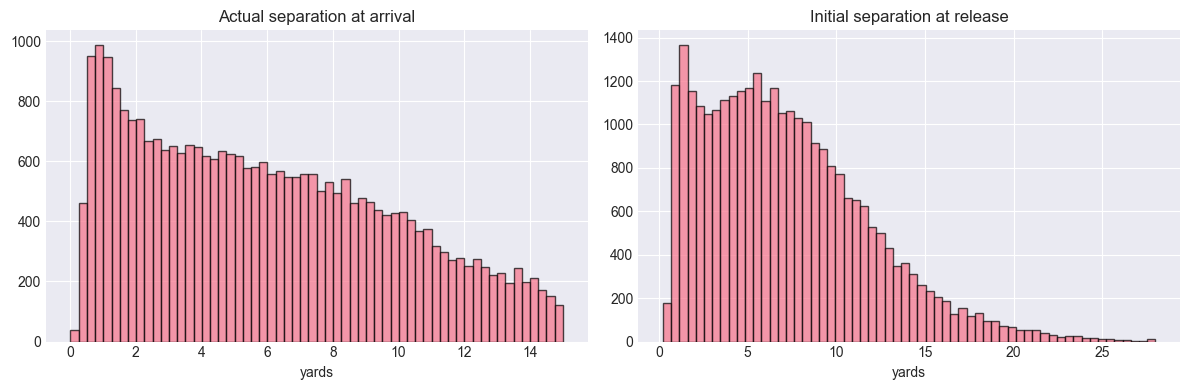

Rows with extreme z-scores in core numerics: 16


In [ ]:

print("Rows:", len(df), "| Columns:", df.shape[1])
print("\nInfo:")
df.info(memory_usage="deep")

na_pct = df.isna().mean().sort_values(ascending=False)
print("\nMissingness (top 20):")
print((na_pct * 100).head(20).round(2))

dup_mask = df.duplicated(subset=["game_id","play_id","defenderId"], keep=False)
print("\nPotential duplicate defender-rows within a play:", dup_mask.sum())

cat_cols = ["route","coverage_man_zone","coverage_type","pass_location_type","down_cat"]
card = df[cat_cols].astype("object").nunique().sort_values(ascending=False)
print("\nCategorical cardinality:")
print(card)

print("\nAny UNKNOWN left?",
      ((df["coverage_man_zone"].astype(str)=="UNKNOWN") | (df["coverage_type"].astype(str)=="UNKNOWN")).any())

num_cols = ["sep_arrival_def" ,"time_in_air","def_to_rec_dist_release",
            "def_speed_release","rec_speed_release"]
print("\nNumeric describe (selected):")
print(df[num_cols].describe(percentiles=[.01,.05,.5,.95,.99]).T)


fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(df["sep_arrival_def"].clip(0,20), bins=60, edgecolor="black", alpha=0.7)
ax[0].set_title("Actual separation at arrival")
ax[0].set_xlabel("yards")

ax[1].hist(df["sep_release_def"].clip(0,28), bins=60, edgecolor="black", alpha=0.7)
ax[1].set_title("Initial separation at release")
ax[1].set_xlabel("yards")

plt.tight_layout()
plt.savefig("eda_target_hist.png", dpi=160); plt.show()

core_num = ["time_in_air","def_to_rec_dist_release","def_to_ball_dist_release",
            "def_speed_release","rec_speed_release"]
z = df[core_num].apply(lambda s: (s - s.mean())/s.std(ddof=0))
outlier_rows = (z.abs() > 5).any(axis=1)
print("Rows with extreme z-scores in core numerics:", outlier_rows.sum())


In [ ]:
target = "sep_arrival_def"
num_for_corr = ["time_in_air","def_to_rec_dist_release","def_to_ball_dist_release",
                "def_speed_release","def_accel_release","rec_speed_release",
                "rec_accel_release" ,"yards_to_go","yardline_number"]

corr = df[num_for_corr + [target]].corr(numeric_only=True)[target].sort_values(ascending=False)
print("\nCorrelation with target (top -> bottom):")
print(corr)

for c in ["route","coverage_type","coverage_man_zone","pass_location_type","down_cat", "ytg_bin"]:
    vc = df[c].astype("object").value_counts(dropna=False)
    print(f"\n{c} counts (top 20):")
    print(vc.head(20))



Correlation with target (top -> bottom):
sep_arrival_def             1.000000
def_to_rec_dist_release     0.589102
def_to_ball_dist_release    0.258713
rec_speed_release           0.084347
time_in_air                 0.063112
yardline_number             0.016912
yards_to_go                 0.015110
rec_accel_release          -0.003602
def_speed_release          -0.044228
def_accel_release          -0.228500
Name: sep_arrival_def, dtype: float64

route counts (top 20):
route
HITCH     5877
OUT       4308
GO        3456
IN        3277
CROSS     3010
POST      2524
SLANT     2400
FLAT      2125
CORNER    1391
ANGLE      609
SCREEN     268
Name: count, dtype: int64

coverage_type counts (top 20):
coverage_type
COVER_3_ZONE    9292
COVER_1_MAN     6942
COVER_4_ZONE    4944
COVER_2_ZONE    3502
COVER_6_ZONE    2792
COVER_0_MAN     1221
COVER_2_MAN      552
Name: count, dtype: int64

coverage_man_zone counts (top 20):
coverage_man_zone
ZONE_COVERAGE    20530
MAN_COVERAGE      8715
Name: coun

## Checking Outliers

Extreme rows found (|z|>5): 16


,week,_z_triggers,game_id,play_id,receiverId,receiverName,defenderId,defenderName,route,coverage_man_zone,coverage_type,sep_arrival_def,time_in_air,def_to_rec_dist_release,def_to_ball_dist_release,rec_speed_release,def_speed_release,rec_accel_release,def_accel_release,_max_abs_z
1732,1,time_in_air,2023091100,3167,54475,Garrett Wilson,54650,Christian Benford,CORNER,ZONE_COVERAGE,COVER_2_ZONE,3.761929,9.4,6.022889,18.464609,7.07,6.45,3.06,2.76,15.678192
1733,1,time_in_air,2023091100,3167,54475,Garrett Wilson,40166,Jordan Poyer,CORNER,ZONE_COVERAGE,COVER_2_ZONE,3.221335,9.4,10.088621,7.881243,7.07,5.08,3.06,3.42,15.678192
1734,1,time_in_air,2023091100,3167,54475,Garrett Wilson,44976,Matt Milano,CORNER,ZONE_COVERAGE,COVER_2_ZONE,9.536426,9.4,16.466347,28.461246,7.07,2.12,3.06,1.53,15.678192
1735,1,time_in_air,2023091100,3167,54475,Garrett Wilson,40107,Micah Hyde,CORNER,ZONE_COVERAGE,COVER_2_ZONE,7.757350,9.4,20.512440,26.598078,7.07,4.52,3.06,2.84,15.678192
1736,1,time_in_air,2023091100,3167,54475,Garrett Wilson,46190,Taron Johnson,CORNER,ZONE_COVERAGE,COVER_2_ZONE,5.996941,9.4,6.518014,20.356405,7.07,1.71,3.06,2.38,15.678192
1737,1,time_in_air,2023091100,3167,54475,Garrett Wilson,54554,Terrel Bernard,CORNER,ZONE_COVERAGE,COVER_2_ZONE,7.573380,9.4,11.653610,21.412014,7.07,4.16,3.06,2.16,15.678192
1738,1,time_in_air,2023091100,3167,54475,Garrett Wilson,44839,Tre'Davious White,CORNER,ZONE_COVERAGE,COVER_2_ZONE,13.349026,9.4,24.202961,33.908573,7.07,3.76,3.06,0.76,15.678192
24250,16,time_in_air,2023122100,1450,43415,Demarcus Robinson,54514,Alontae Taylor,OUT,ZONE_COVERAGE,COVER_3_ZONE,2.782983,5.5,14.996359,10.982405,5.22,3.90,5.55,4.66,8.219208
24254,16,time_in_air,2023122100,1450,43415,Demarcus Robinson,53489,Pete Werner,OUT,ZONE_COVERAGE,COVER_3_ZONE,10.140492,5.5,13.277424,24.687086,5.22,1.97,5.55,6.21,8.219208
24251,16,time_in_air,2023122100,1450,43415,Demarcus Robinson,56011,Jordan Howden,OUT,ZONE_COVERAGE,COVER_3_ZONE,4.497509,5.5,13.589280,24.350224,5.22,3.44,5.55,5.83,8.219208


Saved full list to suspected_outlier_rows.csv
_n_triggers
1    15
2     1
Name: count, dtype: int64


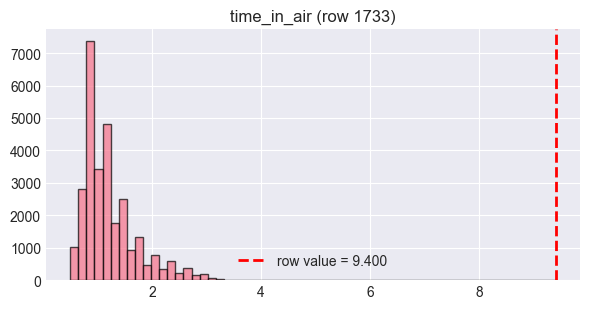

In [ ]:
core_num_cols = [
    "sep_arrival_def" ,
    "def_to_rec_dist_release","def_to_ball_dist_release",
    "time_in_air","rec_speed_release","def_speed_release",
    "rec_accel_release","def_accel_release"
]

core_num_cols = [c for c in core_num_cols if c in df.columns]

zs = pd.DataFrame(index=df.index)
for c in core_num_cols:
    m = df[c].mean()
    s = df[c].std(ddof=0)
    zs[c] = 0.0 if (s == 0 or np.isnan(s)) else (df[c] - m) / s

# flag rows with any absolute z-score beyond threshold
Z_THR = 5   
outlier_mask = (zs.abs() > Z_THR).any(axis=1)

print(f"Extreme rows found (|z|>{Z_THR}): {int(outlier_mask.sum())}")

trigger_cols = zs.columns
trigger_str = zs[outlier_mask].abs().apply(
    lambda r: ", ".join([c for c in trigger_cols if r[c] > Z_THR]),
    axis=1
)

cols_for_view = [
    "week","game_id","play_id","receiverId","receiverName","defenderId","defenderName",
    "route","coverage_man_zone","coverage_type",
    "sep_arrival_def","time_in_air","def_to_rec_dist_release","def_to_ball_dist_release",
    "rec_speed_release","def_speed_release","rec_accel_release","def_accel_release"
]
cols_for_view = [c for c in cols_for_view if c in df.columns]

sus = df.loc[outlier_mask, cols_for_view].copy()
sus.insert(1, "_z_triggers", trigger_str.values)

sus["_max_abs_z"] = zs.loc[outlier_mask].abs().max(axis=1).values
sus = sus.sort_values("_max_abs_z", ascending=False)

display(sus.head(50))
sus.to_csv("suspected_outlier_rows.csv", index=False)
print("Saved full list to suspected_outlier_rows.csv")

sus["_n_triggers"] = zs.loc[outlier_mask].abs().gt(Z_THR).sum(axis=1).values
print(sus["_n_triggers"].value_counts().sort_index())

def inspect_row_hist(row_idx, bins=60):
    """Plot hist for each triggering feature and vertical line at that row's value."""
    import matplotlib.pyplot as plt
    trig = zs.columns[zs.loc[row_idx].abs() > Z_THR].tolist()
    if not trig:
        print("No triggers for this row.")
        return
    for c in trig:
        plt.figure(figsize=(6,3.2))
        plt.hist(df[c], bins=bins, edgecolor="black", alpha=0.7)
        plt.axvline(df.loc[row_idx, c], color="red", linestyle="--", linewidth=2, label=f"row value = {df.loc[row_idx, c]:.3f}")
        plt.title(f"{c} (row {row_idx})")
        plt.legend(); plt.tight_layout(); plt.show()

if not sus.empty:
    extreme_idx = sus.index[1]
    inspect_row_hist(extreme_idx)


## Transforming the data and adding physics features

In [ ]:
# Angle transformation function
def add_angle_sin_cos(X: pd.DataFrame):
    X = X.copy()
    for c in angle_cols:
        rad = np.deg2rad(X[c].fillna(0.0))
        X[f"{c}_sin"] = np.sin(rad)
        X[f"{c}_cos"] = np.cos(rad)
    X.drop(columns=angle_cols, inplace=True)
    return X

angle_featurizer = FunctionTransformer(add_angle_sin_cos, validate=False)

# Prepare data
numeric_features = [
    "time_in_air",
    "ball_land_x","ball_land_y","rec_to_ball_dist",
    "rec_x_release","rec_y_release","rec_speed_release","rec_accel_release",
    "def_x_release","def_y_release","def_speed_release","def_accel_release",
    "def_to_rec_dist_release","def_to_ball_dist_release",
    "def_closing_speed_to_rec","def_closing_speed_to_ball",
    "rec_toward_def_speed",
    "sep_release_def",                
    "global_min_sep_at_release"       
]

df["sep_arrival_def"] = df["sep_arrival_def"].clip(lower=0, upper=20)

X_all = df[categorical_features + angle_cols + numeric_features].copy()
y_all = df["sep_arrival_def"].values

X_before = X_all.copy()

core_tail_cols = [
    "time_in_air","def_to_rec_dist_release","def_to_ball_dist_release",
    "rec_speed_release","def_speed_release",
    "def_closing_speed_to_rec","def_closing_speed_to_ball"
]
lower_q, upper_q = 0.00001, 0.9995

caps_lo = {c: X_all.loc[train_idx, c].quantile(lower_q) for c in core_tail_cols}
caps_hi = {c: X_all.loc[train_idx, c].quantile(upper_q) for c in core_tail_cols}

keep_mask = pd.Series(True, index=X_all.index)
for c in core_tail_cols:
    keep_mask &= (X_all[c] >= caps_lo[c]) & (X_all[c] <= caps_hi[c])

# Apply the mask to X_all, y_all, and df
idx_keep = keep_mask[keep_mask].index
X_all = X_all.loc[idx_keep].copy()
y_all = y_all[keep_mask.values]
df    = df.loc[idx_keep].reset_index(drop=True)

# recompute masks from the filtered df using the SAME week sets
train_idx = df["week"].isin(train_weeks).values
test_idx  = df["week"].isin(test_weeks).values

# Physics features testing different feature enginnering
def add_physics_feats(df_in):
    df_out = df_in.copy()
    # df_out["closing_frac_to_rec"] = (
    #     df_out["def_closing_speed_to_rec"] * df_out["time_in_air"]
    # ) / (df_out["def_to_rec_dist_release"] + 1e-3)
    if "def_turn_to_rec" in df_out.columns:
        df_out["turn_cost"] = (df_out["def_turn_to_rec"].abs() / 180.0) * (1.0 / (df_out["def_speed_release"] + 0.5))
    else:
        df_out["turn_cost"] = 0.0
    df_out["relative_speed"] = df_out["def_speed_release"] - df_out["rec_speed_release"]
    return df_out

X_all = add_physics_feats(X_all)
# # physics interactions
#X_all["is_man"] = df["is_man"].astype("float32")
# X_all["turn_cost"] = X_all.get("turn_cost", 0.0)  # if not added earlier, ensure it exists
# X_all["relative_speed"] = X_all.get("relative_speed", 0.0)

# # interactions
# X_all["is_man_x_turn_cost"]     = X_all["is_man"] * X_all["turn_cost"]
# X_all["is_man_x_relative_speed"] = X_all["is_man"] * X_all["relative_speed"]
# X_all["tair_x_close_rec"]       = X_all["time_in_air"] * X_all["def_closing_speed_to_rec"]

# extend numerics list so the preprocessor keeps them
for _c in ["turn_cost","relative_speed",
           #"is_man_x_turn_cost","is_man_x_relative_speed","tair_x_close_rec"
           ]:
    if _c not in numeric_features: numeric_features.append(_c)


X_train = X_all.loc[train_idx].copy()
X_test  = X_all.loc[test_idx].copy()
y_train = y_all[train_idx]
y_test  = y_all[test_idx]

#Rare category squashing
for col, min_count in [("coverage_type", 50)]:
    vc = X_train[col].value_counts()
    rare = set(vc[vc < min_count].index)
    squash = (lambda x: "OTHER" if x in rare else x)
    X_train[col] = X_train[col].map(squash)
    X_test[col]  = X_test[col].map(squash)
    X_all[col]   = X_all[col].map(squash)

print("✓ Dropped outliers instead of clipping.")
drop_rows = (~keep_mask).sum()
print(f"Dropped {int(drop_rows):,} rows ({drop_rows/len(keep_mask)*100:.2f}%) based on train-derived bounds.")
for c in core_tail_cols:
    n_low  = (X_before[c] < caps_lo[c]).sum()
    n_high = (X_before[c] > caps_hi[c]).sum()
    print(f"  {c}: below {n_low:,}, above {n_high:,} (bounds [{caps_lo[c]:.4g}, {caps_hi[c]:.4g}])")


✓ Dropped outliers instead of clipping.
Dropped 110 rows (0.38%) based on train-derived bounds.
  time_in_air: below 0, above 16 (bounds [0.5, 3.4])
  def_to_rec_dist_release: below 1, above 14 (bounds [0.2351, 27.03])
  def_to_ball_dist_release: below 1, above 22 (bounds [0.07575, 33.53])
  rec_speed_release: below 1, above 9 (bounds [0.004867, 9.96])
  def_speed_release: below 0, above 19 (bounds [0.04, 9.437])
  def_closing_speed_to_rec: below 1, above 18 (bounds [-9.515, 8.52])
  def_closing_speed_to_ball: below 1, above 16 (bounds [-8.618, 8.209])


## Dropping extreme Outliers from model training

In [9]:
def show_capped_examples(col, k=20):
    lo, hi = caps_lo[col], caps_hi[col]
    was_outside = (X_before[col] < lo) | (X_before[col] > hi)
    ex = pd.concat([
        X_before.loc[was_outside, [col]].rename(columns={col: f"{col}_before"}),
        X_all.loc[was_outside,  [col]].rename(columns={col: f"{col}_after"})
    ], axis=1)
    # Join back IDs to inspect the play if you like:
    ex = ex.join(df.loc[ex.index, ["game_id","play_id","week","receiverName","defenderName"]])
    return ex.head(k)

display(show_capped_examples("time_in_air"))


,time_in_air_before,time_in_air_after,game_id,play_id,week,receiverName,defenderName
1732,9.4,NaN,2023091400,3413,2,Justin Jefferson,Nicholas Morrow
1733,9.4,NaN,2023091400,3413,2,Justin Jefferson,Zach Cunningham
1734,9.4,NaN,2023091400,2587,2,Dallas Goedert,Byron Murphy
1735,9.4,NaN,2023091400,2587,2,Dallas Goedert,Camryn Bynum
1736,9.4,NaN,2023091400,2587,2,Dallas Goedert,Harrison Smith
1737,9.4,NaN,2023091400,1767,2,Jordan Addison,Josh Jobe
1738,9.4,NaN,2023091400,1767,2,Jordan Addison,Justin Evans
3968,3.6,NaN,2023092403,474,3,Tony Jones,Quay Walker
9197,3.6,NaN,2023101505,3019,6,Nico Collins,Marcus Maye
9198,3.6,NaN,2023101505,3019,6,Nico Collins,Marshon Lattimore


## Training the Model on the Best Paramaters Found from Optuna Search

In [ ]:
# weights
df["rows_in_play"] = df.groupby(["game_id","play_id"])["defenderId"].transform("size")
df["sample_weight"] = 1.0 
train_sw = df.loc[train_idx, "sample_weight"].values.astype("float32")
test_sw  = df.loc[test_idx,  "sample_weight"].values.astype("float32")

np.random.seed(42)
torch.manual_seed(42)

# TARGET ENCODING 
def _prep_cat(s):
    s = s.astype("object").where(pd.notna(s), "__MISSING__")
    return s

def target_encode_oof(train_cat, y_train, w_train, groups, k_prior=300.0):
    """
    OOF target encoding with smoothing:
      enc = (sum(w*y) + k * global_mean) / (sum(w) + k)
    Returns: oof_enc (for the provided rows), full_map (for inference), global_mean
    """

    train_cat = _prep_cat(pd.Series(train_cat).reset_index(drop=True))
    y_train = np.asarray(y_train, dtype="float32")
    w_train = np.asarray(w_train, dtype="float32")
    groups  = np.asarray(groups)

    if len(train_cat) == 0:
        return np.array([], dtype="float32"), {}, float("nan")

    gm = float(np.average(y_train, weights=w_train))

    # OOF encodings
    enc = np.full(train_cat.shape[0], gm, dtype="float32")
    n_splits = min(5, max(2, np.unique(groups).size))
    cv = GroupKFold(n_splits=n_splits)
    for tr_idx, va_idx in cv.split(np.zeros_like(groups), groups=groups):
        cat_tr = train_cat.iloc[tr_idx]
        y_tr   = y_train[tr_idx]
        w_tr   = w_train[tr_idx]
        g = pd.DataFrame({"cat": cat_tr, "y": y_tr, "w": w_tr}).groupby("cat", observed=True)
        sum_w  = g["w"].sum()
        sum_wy = g.apply(lambda d: float((d["w"] * d["y"]).sum()))
        sm = (sum_wy + k_prior * gm) / (sum_w + k_prior)
        m = sm.to_dict()
        enc[va_idx] = pd.Series(train_cat.iloc[va_idx]).map(m).fillna(gm).astype("float32").to_numpy()

    # Full map on ALL provided rows
    g_all = pd.DataFrame({"cat": train_cat, "y": y_train, "w": w_train}).groupby("cat", observed=True)
    sum_w_all  = g_all["w"].sum()
    sum_wy_all = g_all.apply(lambda d: float((d["w"] * d["y"]).sum()))
    sm_all = (sum_wy_all + k_prior * gm) / (sum_w_all + k_prior)
    full_map = sm_all.to_dict()

    return enc, full_map, gm

def apply_target_map(series, mapping, global_mean):
    s = _prep_cat(pd.Series(series))
    return s.map(mapping).fillna(global_mean).astype("float32").to_numpy()

def _is_man_series(s):
    return (s.astype(str).str.upper() == "MAN_COVERAGE")

# Columns to encode
te_cols = ["coverage_type", "coverage_man_zone", "route_squash","defenderGroup","ytg_bin","receiverId_key"]

weeks_train = df.loc[train_idx, "week"].to_numpy()

train_is_man  = _is_man_series(X_train["coverage_man_zone"]).to_numpy()
train_is_zone = ~train_is_man

GLOBAL_MEAN = float(np.average(y_train, weights=train_sw))

te_train = {}   
te_test  = {}   
te_maps  = { "MAN": {}, "ZONE": {} }
te_gmean = { "MAN": GLOBAL_MEAN, "ZONE": GLOBAL_MEAN }

# Precompute test regime mask for routing
test_is_man = _is_man_series(X_test["coverage_man_zone"]).to_numpy()

BEST_CFG = {
    "k_prior": 1200,#1248.3552828192512,
    "d_hidden": 256,
    "drop": 0.11,
    "weight_decay": 3.362799602578194e-05,
    "lr": .003,
    "huber_delta": 0.6150049494175176,
}
FIXED = {
    "patience": 20,
    "batch_size": 256,
    "max_epochs": 160,
    "grad_clip": 0.7,
}

# ANGLES
print("\n" + "="*70)
print("TRAINING MODEL — Torch MLP with Regime-Specific TE [HARD-CODED PARAMS]")
print("="*70)

for col in te_cols:
    # Man slice
    if train_is_man.any():
        enc_man, map_man, gm_man = target_encode_oof(
            train_cat=X_train.loc[train_is_man, col],
            y_train=y_train[train_is_man],
            w_train=train_sw[train_is_man],
            groups=weeks_train[train_is_man],
            k_prior=BEST_CFG["k_prior"]
        )
        te_maps["MAN"][col] = map_man
        te_gmean["MAN"] = gm_man
    else:
        enc_man = np.array([], dtype="float32")
        te_maps["MAN"][col] = {}
        te_gmean["MAN"] = GLOBAL_MEAN

    # Zone slice
    if train_is_zone.any():
        enc_zone, map_zone, gm_zone = target_encode_oof(
            train_cat=X_train.loc[train_is_zone, col],
            y_train=y_train[train_is_zone],
            w_train=train_sw[train_is_zone],
            groups=weeks_train[train_is_zone],
            k_prior=BEST_CFG["k_prior"]
        )
        te_maps["ZONE"][col] = map_zone
        te_gmean["ZONE"] = gm_zone
    else:
        enc_zone = np.array([], dtype="float32")
        te_maps["ZONE"][col] = {}
        te_gmean["ZONE"] = GLOBAL_MEAN

    enc_full_train = np.empty(len(X_train), dtype="float32")
    if train_is_man.any():
        enc_full_train[train_is_man] = enc_man
    else:
        enc_full_train[train_is_man] = GLOBAL_MEAN
    if train_is_zone.any():
        enc_full_train[train_is_zone] = enc_zone
    else:
        enc_full_train[train_is_zone] = GLOBAL_MEAN
    te_train[col] = enc_full_train

    test_vec = np.empty(len(X_test), dtype="float32")
    if test_is_man.any():
        test_vec[test_is_man] = apply_target_map(
            X_test.loc[test_is_man, col],
            te_maps["MAN"][col],
            te_gmean["MAN"]
        )
    if (~test_is_man).any():
        test_vec[~test_is_man] = apply_target_map(
            X_test.loc[~test_is_man, col],
            te_maps["ZONE"][col],
            te_gmean["ZONE"]
        )
    te_test[col] = test_vec

# Angle featurization
X_train_angle = angle_featurizer.transform(X_train)
X_test_angle  = angle_featurizer.transform(X_test)

for col in te_cols:
    new_name = f"te__{col}"
    X_train_angle[new_name] = te_train[col]
    X_test_angle[new_name]  = te_test[col]

Xtr_num_df = X_train_angle.drop(columns=categorical_features, errors="ignore")
Xte_num_df = X_test_angle.drop(columns=categorical_features, errors="ignore")

num_cols = Xtr_num_df.columns
Xte_num_df = Xte_num_df.reindex(columns=num_cols, fill_value=0.0)

MED = Xtr_num_df.median(axis=0).fillna(0.0) 
Xtr_imp = Xtr_num_df.fillna(MED)
MU = Xtr_imp.mean(axis=0)
SD = Xtr_imp.std(axis=0).replace(0.0, 1.0)

def _standardize_frame(df_in):
    f = df_in.reindex(columns=num_cols, fill_value=0.0).astype("float32")
    f = f.fillna(MED)
    f = (f - MU).divide(SD)
    f = f.replace([np.inf, -np.inf], 0.0).fillna(0.0)
    return f

def _names_out(_transformer, _input_features=None):
    return np.array(num_cols, dtype=object)

preprocess = FunctionTransformer(
    lambda df: _standardize_frame(df),
    validate=False,
    feature_names_out=_names_out,
)

pre_only = Pipeline(steps=[
    ("angle", angle_featurizer),
    ("preprocess", preprocess),
])
pre_only.set_output(transform="pandas")
pre_only.fit(X_train)  

Xtr_all_std = _standardize_frame(X_train_angle).to_numpy(dtype="float32")
y_tr_all    = y_train.astype("float32")
w_tr_all    = train_sw.astype("float32")


class MLP(nn.Module):
    def __init__(self, d_in, d_hidden=384, drop=0.15):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, d_hidden), nn.BatchNorm1d(d_hidden), nn.SiLU(),
            nn.Dropout(drop),
            nn.Linear(d_hidden, d_hidden // 2), nn.BatchNorm1d(d_hidden // 2), nn.SiLU(),
            nn.Dropout(drop),
            nn.Linear(d_hidden // 2, 1),
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

class TorchMLPRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, d_in, d_hidden=384, drop=0.15, lr=2e-3, weight_decay=5e-4,
                 batch_size=512, max_epochs=160, patience=12, huber_delta=0.75,
                 grad_clip=1.0, device=None, seed=42):
        self.d_in=d_in; self.d_hidden=d_hidden; self.drop=drop
        self.lr=lr; self.weight_decay=weight_decay
        self.batch_size=batch_size; self.max_epochs=max_epochs; self.patience=patience
        self.huber_delta=huber_delta; self.grad_clip=grad_clip
        self.device=device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.seed=seed
        self._model=None; self._best_state=None

    def _set_seed(self):
        np.random.seed(self.seed); torch.manual_seed(self.seed)
        if torch.cuda.is_available(): torch.cuda.manual_seed_all(self.seed)

    def fit(self, X_tr, y_tr, X_va=None, y_va=None, w_tr=None, w_va=None):
        self._set_seed()
        X_tr = np.asarray(X_tr, dtype="float32"); y_tr = np.asarray(y_tr, dtype="float32")
        w_tr = np.ones_like(y_tr, dtype="float32") if w_tr is None else np.asarray(w_tr, dtype="float32")
        if X_va is not None:
            X_va = np.asarray(X_va, dtype="float32"); y_va = np.asarray(y_va, dtype="float32")
            w_va = np.ones_like(y_va, dtype="float32") if w_va is None else np.asarray(w_va, dtype="float32")

        self._model = MLP(self.d_in, self.d_hidden, self.drop).to(self.device)
        opt = torch.optim.AdamW(self._model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        huber = nn.HuberLoss(delta=self.huber_delta, reduction="none")
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)

        tr_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr), torch.from_numpy(w_tr))
        tr_loader = DataLoader(tr_ds, batch_size=self.batch_size, shuffle=True, drop_last=False)

        best_va = float("inf"); no_improve = 0
        for _ in range(self.max_epochs):
            self._model.train()
            for xb, yb, wb in tr_loader:
                xb, yb, wb = xb.to(self.device), yb.to(self.device), wb.to(self.device)
                opt.zero_grad()
                pred = self._model(xb)
                loss = (huber(pred, yb) * wb).mean()
                loss.backward()
                if self.grad_clip is not None:
                    nn.utils.clip_grad_norm_(self._model.parameters(), self.grad_clip)
                opt.step()

            if X_va is not None:
                self._model.eval()
                with torch.no_grad():
                    pv = self._model(torch.from_numpy(X_va).to(self.device)).cpu().numpy()
                va_mae = float(np.average(np.abs(pv - y_va), weights=w_va))
                scheduler.step(va_mae)
                if va_mae < best_va - 1e-5:
                    best_va = va_mae; no_improve = 0
                    self._best_state = {k:v.detach().clone() for k,v in self._model.state_dict().items()}
                else:
                    no_improve += 1
                    if no_improve >= self.patience:
                        break

        if self._best_state is not None:
            self._model.load_state_dict(self._best_state)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype="float32")
        self._model.eval()
        with torch.no_grad():
            p = self._model(torch.from_numpy(X).to(self.device)).cpu().numpy()
        return p

# Train/Val split by week 
weeks_tr_only = df.loc[train_idx, "week"].to_numpy()
uniq_weeks = np.sort(np.unique(weeks_tr_only))
val_weeks = set(uniq_weeks[-2:]) if uniq_weeks.size >= 2 else set([uniq_weeks[-1]])
va_sel = np.isin(weeks_tr_only, list(val_weeks))
tr_sel = ~va_sel

def _is_man_series(s):
    return (s.astype(str).str.upper() == "MAN_COVERAGE")

train_is_man = _is_man_series(X_train["coverage_man_zone"]).to_numpy()
tr_man = tr_sel & train_is_man
va_man = va_sel & train_is_man

tr_zone = tr_sel & (~train_is_man)
va_zone = va_sel & (~train_is_man)

print(f"Train rows — MAN (train/val): {tr_man.sum():,}/{va_man.sum():,} | "
      f"ZONE (train/val): {tr_zone.sum():,}/{va_zone.sum():,}")


def fit_side_final(X_std, y_all, w_all, tr_mask, va_mask, seeds_final):
    if not tr_mask.any() or not va_mask.any():
        return None, None
    members = []
    va_pred_agg = None
    for s in seeds_final:
        est = TorchMLPRegressor(
            d_in=X_std.shape[1],
            d_hidden=int(BEST_CFG["d_hidden"]),
            drop=float(BEST_CFG["drop"]),
            weight_decay=float(BEST_CFG["weight_decay"]),
            huber_delta=float(BEST_CFG["huber_delta"]),
            patience=FIXED["patience"],
            max_epochs=FIXED["max_epochs"],
            grad_clip=FIXED["grad_clip"],
            lr=float(BEST_CFG["lr"]),
            batch_size=FIXED["batch_size"],
            seed=int(s)
        )
        est.fit(
            X_std[tr_mask], y_all[tr_mask],
            X_va=X_std[va_mask], y_va=y_all[va_mask],
            w_tr=w_all[tr_mask], w_va=w_all[va_mask]
        )
        members.append(est)
        p = est.predict(X_std[va_mask])
        va_pred_agg = p if va_pred_agg is None else np.column_stack([va_pred_agg, p])
    va_mean = None
    if va_pred_agg is not None and va_pred_agg.ndim == 2:
        va_mean = va_pred_agg.mean(axis=1)
    return members, va_mean

seeds_final = [11, 29, 42, 73, 97]
man_members,  man_va_pred  = fit_side_final(Xtr_all_std, y_tr_all, w_tr_all, tr_man,  va_man,  seeds_final)
zone_members, zone_va_pred = fit_side_final(Xtr_all_std, y_tr_all, w_tr_all, tr_zone, va_zone, seeds_final)

# Compute validation weighted MAE across both regimes
val_mae = None
if va_sel.any():
    y_va_full = y_tr_all[va_sel]
    w_va_full = w_tr_all[va_sel]
    va_pred_full = np.empty(va_sel.sum(), dtype="float32")
    if man_va_pred is not None:
        va_pred_full[va_man[va_sel]] = man_va_pred
    if zone_va_pred is not None:
        va_pred_full[va_zone[va_sel]] = zone_va_pred
    val_mae = float(np.average(np.abs(va_pred_full - y_va_full), weights=w_va_full))

print("\n=== CHOSEN (HARD-CODED) CONFIG USED ===")
print(json.dumps({k: BEST_CFG[k] for k in ["k_prior","d_hidden","drop","weight_decay","lr","huber_delta"]}, indent=2))
if val_mae is not None:
    print(f"Validation (held-out weeks) weighted MAE: {val_mae:.4f}")

#Final model details
final_summary = {
    "k_prior":       float(BEST_CFG["k_prior"]),
    "d_hidden":      int(BEST_CFG["d_hidden"]),
    "drop":          float(BEST_CFG["drop"]),
    "weight_decay":  float(BEST_CFG["weight_decay"]),
    "lr":            float(BEST_CFG["lr"]),
    "huber_delta":   float(BEST_CFG["huber_delta"]),
    "patience":      FIXED["patience"],
    "batch_size":    FIXED["batch_size"],
    "max_epochs":    FIXED["max_epochs"],
    "grad_clip":     FIXED["grad_clip"],
    "seeds":         seeds_final,
    "n_features":    int(Xtr_all_std.shape[1]),
    "n_members_MAN": 0 if man_members  is None else len(man_members),
    "n_members_ZONE":0 if zone_members is None else len(zone_members),
}
print("\n=== FINAL MODEL DETAILS ===")
print(json.dumps(final_summary, indent=2))

def _predict_ensemble_np(members, X_std):
    preds = np.stack([m.predict(X_std) for m in members], axis=1)
    return np.mean(preds, axis=1)

def predict_ensemble(X_df):
    X_angle = angle_featurizer.transform(X_df).copy()
    is_man = _is_man_series(X_df["coverage_man_zone"]).to_numpy()
    for col in te_cols:
        vec = np.empty(len(X_df), dtype="float32")
        if is_man.any():
            vec[is_man] = apply_target_map(X_df.loc[is_man, col], te_maps["MAN"][col], te_gmean["MAN"])
        if (~is_man).any():
            vec[~is_man] = apply_target_map(X_df.loc[~is_man, col], te_maps["ZONE"][col], te_gmean["ZONE"])
        X_angle[f"te__{col}"] = vec
    X_std = _standardize_frame(X_angle).to_numpy(dtype="float32")

    out = np.empty(X_std.shape[0], dtype="float32")
    idx = np.where(is_man)[0]
    if idx.size > 0:
        out[idx] = _predict_ensemble_np(man_members or zone_members, X_std[idx])  # fallback if one side None
    idx = np.where(~is_man)[0]
    if idx.size > 0:
        out[idx] = _predict_ensemble_np(zone_members or man_members, X_std[idx])
    if np.isnan(out).any():
        out = np.nan_to_num(out, nan=np.nanmean(out))
    return out

train_pred = predict_ensemble(X_train)
test_pred  = predict_ensemble(X_test)
rmse = lambda y, p: float(np.sqrt(((y - p) ** 2).mean()))

print("\n" + "="*70)
print("MODEL PERFORMANCE — Split Torch MLP (Man vs Zone) [HARD-CODED PARAMS]")
print("="*70)
train_r2   = r2_score(y_train, train_pred)
test_r2    = r2_score(y_test,  test_pred)
train_mae  = mean_absolute_error(y_train, train_pred)
test_mae   = mean_absolute_error(y_test,  test_pred)
train_rmse = rmse(y_train, train_pred)
test_rmse  = rmse(y_test,  test_pred)
print(f"\nTrain: R² = {train_r2:.4f} | MAE = {train_mae:.3f} yards | RMSE = {train_rmse:.3f} yards")
print(f"Test : R² = {test_r2:.4f} | MAE = {test_mae:.3f} yards | RMSE = {test_rmse:.3f} yards")



BUILDING PIPELINE — Torch MLP (numeric + target encodings) [HARD-CODED PARAMS]

TRAINING MODEL — Torch MLP with Regime-Specific TE [HARD-CODED PARAMS]
Train rows — MAN (train/val): 6,228/961 | ZONE (train/val): 14,691/2,375

=== CHOSEN (HARD-CODED) CONFIG USED ===
{
  "k_prior": 1200,
  "d_hidden": 256,
  "drop": 0.11,
  "weight_decay": 3.362799602578194e-05,
  "lr": 0.003,
  "huber_delta": 0.6150049494175176
}
Validation (held-out weeks) weighted MAE: 1.0609

=== FINAL MODEL DETAILS ===
{
  "k_prior": 1200.0,
  "d_hidden": 256,
  "drop": 0.11,
  "weight_decay": 3.362799602578194e-05,
  "lr": 0.003,
  "huber_delta": 0.6150049494175176,
  "patience": 20,
  "batch_size": 256,
  "max_epochs": 160,
  "grad_clip": 0.7,
  "seeds": [
    11,
    29,
    42,
    73,
    97
  ],
  "n_features": 45,
  "n_members_MAN": 5,
  "n_members_ZONE": 5
}

MODEL PERFORMANCE — Split Torch MLP (Man vs Zone) [HARD-CODED PARAMS]

Train: R² = 0.8941 | MAE = 0.810 yards | RMSE = 1.257 yards
Test : R² = 0.8718 |

## This commented out code below was the Optuna Search Used to Find the Best Parameters

In [ ]:
# import numpy as np
# import pandas as pd
# import torch, torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.base import BaseEstimator, RegressorMixin
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.model_selection import GroupKFold
# import joblib
# from pathlib import Path

# df["rows_in_play"] = df.groupby(["game_id","play_id"])["defenderId"].transform("size")
# df["sample_weight"] = 1.0 / df["rows_in_play"]
# train_sw = df.loc[train_idx, "sample_weight"].values.astype("float32")
# test_sw  = df.loc[test_idx,  "sample_weight"].values.astype("float32")

# # deterministic seeds
# np.random.seed(42)
# torch.manual_seed(42)

# # TARGET ENCODING Regime-specific (MAN vs ZONE)
# def _prep_cat(s):
#     s = s.astype("object").where(pd.notna(s), "__MISSING__")
#     return s

# def target_encode_oof(train_cat, y_train, w_train, groups, k_prior=300.0):
#     import numpy as np, pandas as pd
#     from sklearn.model_selection import GroupKFold

#     train_cat = _prep_cat(pd.Series(train_cat).reset_index(drop=True))
#     y_train = np.asarray(y_train, dtype="float32")
#     w_train = np.asarray(w_train, dtype="float32")
#     groups  = np.asarray(groups)

#     if len(train_cat) == 0:
#         return np.array([], dtype="float32"), {}, float("nan")

#     # Weighted global mean for shrinkage
#     gm = float(np.average(y_train, weights=w_train))

#     # OOF encodings
#     enc = np.full(train_cat.shape[0], gm, dtype="float32")
#     n_splits = min(5, max(2, np.unique(groups).size))
#     cv = GroupKFold(n_splits=n_splits)
#     for tr_idx, va_idx in cv.split(np.zeros_like(groups), groups=groups):
#         cat_tr = train_cat.iloc[tr_idx]
#         y_tr   = y_train[tr_idx]
#         w_tr   = w_train[tr_idx]
#         g = pd.DataFrame({"cat": cat_tr, "y": y_tr, "w": w_tr}).groupby("cat", observed=True)
#         sum_w  = g["w"].sum()
#         sum_wy = g.apply(lambda d: float((d["w"] * d["y"]).sum()))
#         sm = (sum_wy + k_prior * gm) / (sum_w + k_prior)
#         m = sm.to_dict()
#         enc[va_idx] = pd.Series(train_cat.iloc[va_idx]).map(m).fillna(gm).astype("float32").to_numpy()

#     # Full map on ALL provided rows
#     g_all = pd.DataFrame({"cat": train_cat, "y": y_train, "w": w_train}).groupby("cat", observed=True)
#     sum_w_all  = g_all["w"].sum()
#     sum_wy_all = g_all.apply(lambda d: float((d["w"] * d["y"]).sum()))
#     sm_all = (sum_wy_all + k_prior * gm) / (sum_w_all + k_prior)
#     full_map = sm_all.to_dict()

#     return enc, full_map, gm

# def apply_target_map(series, mapping, global_mean):
#     s = _prep_cat(pd.Series(series))
#     return s.map(mapping).fillna(global_mean).astype("float32").to_numpy()

# def _is_man_series(s):
#     return (s.astype(str).str.upper() == "MAN_COVERAGE")

# # Columns to encode
# te_cols = ["coverage_type", "coverage_man_zone", "route_squash","defenderGroup","receiverId_key", "ytg_bin"]

# # Train/val week groups
# weeks_train = df.loc[train_idx, "week"].to_numpy()

# # Regime masks on TRAIN
# train_is_man  = _is_man_series(X_train["coverage_man_zone"]).to_numpy()
# train_is_zone = ~train_is_man

# # Global fallback mean
# GLOBAL_MEAN = float(np.average(y_train, weights=train_sw))

# # regime-specific OOF encodings on TRAIN, plus per-regime maps for TEST
# te_train = {}   
# te_test  = {}   
# te_maps  = { "MAN": {}, "ZONE": {} }
# te_gmean = { "MAN": GLOBAL_MEAN, "ZONE": GLOBAL_MEAN }

# # Precompute test regime mask for routing
# test_is_man = _is_man_series(X_test["coverage_man_zone"]).to_numpy()

# for col in te_cols:
#     # MAN slice
#     if train_is_man.any():
#         enc_man, map_man, gm_man = target_encode_oof(
#             train_cat=X_train.loc[train_is_man, col],
#             y_train=y_train[train_is_man],
#             w_train=train_sw[train_is_man],
#             groups=weeks_train[train_is_man],
#             k_prior=600.0
#         )
#         te_maps["MAN"][col] = map_man
#         te_gmean["MAN"] = gm_man
#     else:
#         enc_man = np.array([], dtype="float32")
#         te_maps["MAN"][col] = {}
#         te_gmean["MAN"] = GLOBAL_MEAN

#     # ZONE slice
#     if train_is_zone.any():
#         enc_zone, map_zone, gm_zone = target_encode_oof(
#             train_cat=X_train.loc[train_is_zone, col],
#             y_train=y_train[train_is_zone],
#             w_train=train_sw[train_is_zone],
#             groups=weeks_train[train_is_zone],
#             k_prior=600.0
#         )
#         te_maps["ZONE"][col] = map_zone
#         te_gmean["ZONE"] = gm_zone
#     else:
#         enc_zone = np.array([], dtype="float32")
#         te_maps["ZONE"][col] = {}
#         te_gmean["ZONE"] = GLOBAL_MEAN

#     # Stitch OOF encodings back to TRAIN rows in place
#     enc_full_train = np.empty(len(X_train), dtype="float32")
#     if train_is_man.any():
#         enc_full_train[train_is_man] = enc_man
#     else:
#         enc_full_train[train_is_man] = GLOBAL_MEAN
#     if train_is_zone.any():
#         enc_full_train[train_is_zone] = enc_zone
#     else:
#         enc_full_train[train_is_zone] = GLOBAL_MEAN
#     te_train[col] = enc_full_train

#     # Build TEST encodings by routing each row to the proper regime map
#     test_vec = np.empty(len(X_test), dtype="float32")
#     if test_is_man.any():
#         test_vec[test_is_man] = apply_target_map(
#             X_test.loc[test_is_man, col],
#             te_maps["MAN"][col],
#             te_gmean["MAN"]
#         )
#     if (~test_is_man).any():
#         test_vec[~test_is_man] = apply_target_map(
#             X_test.loc[~test_is_man, col],
#             te_maps["ZONE"][col],
#             te_gmean["ZONE"]
#         )
#     te_test[col] = test_vec

# # TORCH MLP (Huber + BN + SiLU, LR schedule, grad clip)
# class MLP(nn.Module):
#     def __init__(self, d_in, d_hidden=384, drop=0.15):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(d_in, d_hidden), nn.BatchNorm1d(d_hidden), nn.SiLU(),
#             nn.Dropout(drop),
#             nn.Linear(d_hidden, d_hidden // 2), nn.BatchNorm1d(d_hidden // 2), nn.SiLU(),
#             nn.Dropout(drop),
#             nn.Linear(d_hidden // 2, 1),
#         )
#     def forward(self, x):
#         return self.net(x).squeeze(-1)

# class TorchMLPRegressor(BaseEstimator, RegressorMixin):
#     def __init__(self, d_in, d_hidden=384, drop=0.15, lr=2e-3, weight_decay=5e-4,
#                  batch_size=512, max_epochs=160, patience=12, huber_delta=0.75,
#                  grad_clip=1.0, device=None, seed=42):
#         self.d_in=d_in; self.d_hidden=d_hidden; self.drop=drop
#         self.lr=lr; self.weight_decay=weight_decay
#         self.batch_size=batch_size; self.max_epochs=max_epochs; self.patience=patience
#         self.huber_delta=huber_delta; self.grad_clip=grad_clip
#         self.device=device or ("cuda" if torch.cuda.is_available() else "cpu")
#         self.seed=seed
#         self._model=None; self._best_state=None

#     def _set_seed(self):
#         np.random.seed(self.seed); torch.manual_seed(self.seed)
#         if torch.cuda.is_available(): torch.cuda.manual_seed_all(self.seed)

#     def fit(self, X_tr, y_tr, X_va=None, y_va=None, w_tr=None, w_va=None):
#         self._set_seed()
#         X_tr = np.asarray(X_tr, dtype="float32"); y_tr = np.asarray(y_tr, dtype="float32")
#         w_tr = np.ones_like(y_tr, dtype="float32") if w_tr is None else np.asarray(w_tr, dtype="float32")
#         if X_va is not None:
#             X_va = np.asarray(X_va, dtype="float32"); y_va = np.asarray(y_va, dtype="float32")
#             w_va = np.ones_like(y_va, dtype="float32") if w_va is None else np.asarray(w_va, dtype="float32")

#         self._model = MLP(self.d_in, self.d_hidden, self.drop).to(self.device)
#         opt = torch.optim.AdamW(self._model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
#         huber = nn.HuberLoss(delta=self.huber_delta, reduction="none")
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)


#         tr_ds = TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr), torch.from_numpy(w_tr))
#         tr_loader = DataLoader(tr_ds, batch_size=self.batch_size, shuffle=True, drop_last=False)

#         best_va = float("inf"); no_improve = 0
#         for _ in range(self.max_epochs):
#             self._model.train()
#             for xb, yb, wb in tr_loader:
#                 xb, yb, wb = xb.to(self.device), yb.to(self.device), wb.to(self.device)
#                 opt.zero_grad()
#                 pred = self._model(xb)
#                 loss = (huber(pred, yb) * wb).mean()
#                 loss.backward()
#                 if self.grad_clip is not None:
#                     nn.utils.clip_grad_norm_(self._model.parameters(), self.grad_clip)
#                 opt.step()

#             if X_va is not None:
#                 self._model.eval()
#                 with torch.no_grad():
#                     pv = self._model(torch.from_numpy(X_va).to(self.device)).cpu().numpy()
#                 va_mae = float(np.average(np.abs(pv - y_va), weights=w_va))
#                 scheduler.step(va_mae)
#                 if va_mae < best_va - 1e-5:
#                     best_va = va_mae; no_improve = 0
#                     self._best_state = {k:v.detach().clone() for k,v in self._model.state_dict().items()}
#                 else:
#                     no_improve += 1
#                     if no_improve >= self.patience:
#                         break

#         if self._best_state is not None:
#             self._model.load_state_dict(self._best_state)
#         return self

#     def predict(self, X):
#         X = np.asarray(X, dtype="float32")
#         self._model.eval()
#         with torch.no_grad():
#             p = self._model(torch.from_numpy(X).to(self.device)).cpu().numpy()
#         return p

# weeks_tr_only = df.loc[train_idx, "week"].to_numpy()
# uniq_weeks = np.sort(np.unique(weeks_tr_only))
# val_weeks = set(uniq_weeks[-2:]) if uniq_weeks.size >= 2 else set([uniq_weeks[-1]])
# va_sel = np.isin(weeks_tr_only, list(val_weeks))
# tr_sel = ~va_sel


# y_tr_all    = y_train.astype("float32")
# w_tr_all    = train_sw.astype("float32")

# # Regime masks on TRAIN rows
# def _is_man_series(s):
#     return (s.astype(str).str.upper() == "MAN_COVERAGE")

# train_is_man = _is_man_series(X_train["coverage_man_zone"]).to_numpy()

# # Split within each regime
# tr_man = tr_sel & train_is_man
# va_man = va_sel & train_is_man

# tr_zone = tr_sel & (~train_is_man)
# va_zone = va_sel & (~train_is_man)


# search_seeds = [11, 42, 73]
# seeds = [11, 29, 42, 73, 97]  
# print(f"Train rows — MAN (train/val): {tr_man.sum():,}/{va_man.sum():,} | "
#       f"ZONE (train/val): {tr_zone.sum():,}/{va_zone.sum():,}")

# def rebuild_te_and_std(k_prior):
#     te_train_local, te_test_local = {}, {}
#     for col in te_cols:
#         # MAN slice
#         if train_is_man.any():
#             enc_man, map_man, gm_man = target_encode_oof(
#                 train_cat=X_train.loc[train_is_man, col],
#                 y_train=y_train[train_is_man],
#                 w_train=train_sw[train_is_man],
#                 groups=weeks_train[train_is_man],
#                 k_prior=k_prior
#             )
#             te_maps["MAN"][col] = map_man
#             te_gmean["MAN"] = gm_man
#         else:
#             enc_man = np.array([], dtype="float32")
#             te_maps["MAN"][col] = {}
#             te_gmean["MAN"] = GLOBAL_MEAN

#         # ZONE slice
#         if train_is_zone.any():
#             enc_zone, map_zone, gm_zone = target_encode_oof(
#                 train_cat=X_train.loc[train_is_zone, col],
#                 y_train=y_train[train_is_zone],
#                 w_train=train_sw[train_is_zone],
#                 groups=weeks_train[train_is_zone],
#                 k_prior=k_prior
#             )
#             te_maps["ZONE"][col] = map_zone
#             te_gmean["ZONE"] = gm_zone
#         else:
#             enc_zone = np.array([], dtype="float32")
#             te_maps["ZONE"][col] = {}
#             te_gmean["ZONE"] = GLOBAL_MEAN

#         # stitch train encodings
#         enc_full_train = np.empty(len(X_train), dtype="float32")
#         if train_is_man.any():  enc_full_train[train_is_man]  = enc_man
#         if train_is_zone.any(): enc_full_train[train_is_zone] = enc_zone
#         te_train_local[col] = enc_full_train

#         # build test encodings via maps
#         test_vec = np.empty(len(X_test), dtype="float32")
#         if test_is_man.any():
#             test_vec[test_is_man] = apply_target_map(X_test.loc[test_is_man, col], te_maps["MAN"][col], te_gmean["MAN"])
#         if (~test_is_man).any():
#             test_vec[~test_is_man] = apply_target_map(X_test.loc[~test_is_man, col], te_maps["ZONE"][col], te_gmean["ZONE"])
#         te_test_local[col] = test_vec

#     # angle features append TE
#     X_train_angle_local = angle_featurizer.transform(X_train).copy()
#     X_test_angle_local  = angle_featurizer.transform(X_test).copy()
#     for col in te_cols:
#         X_train_angle_local[f"te__{col}"] = te_train_local[col]
#         X_test_angle_local[f"te__{col}"]  = te_test_local[col]

#     # numeric-only and re-fit standardizer on TRAIN (must re-fit after TE changes)
#     Xtr_num_df_local = X_train_angle_local.drop(columns=categorical_features, errors="ignore")
#     Xte_num_df_local = X_test_angle_local.drop(columns=categorical_features, errors="ignore")
#     num_cols_local = Xtr_num_df_local.columns
#     Xte_num_df_local = Xte_num_df_local.reindex(columns=num_cols_local, fill_value=0.0)

#     MED_local = Xtr_num_df_local.median(axis=0).fillna(0.0)
#     Xtr_imp_local = Xtr_num_df_local.fillna(MED_local)
#     MU_local = Xtr_imp_local.mean(axis=0)
#     SD_local = Xtr_imp_local.std(axis=0).replace(0.0, 1.0)

#     def _standardize_local(df_in):
#         f = df_in.reindex(columns=num_cols_local, fill_value=0.0).astype("float32")
#         f = f.fillna(MED_local)
#         f = (f - MU_local).divide(SD_local)
#         f = f.replace([np.inf, -np.inf], 0.0).fillna(0.0)
#         return f

#     # Return standardized TRAIN arrays and a callable to standardize any DF later if needed
#     Xtr_std_local = _standardize_local(X_train_angle_local).to_numpy(dtype="float32")
#     return Xtr_std_local, _standardize_local

# try:
#     import optuna
#     from optuna.pruners import HyperbandPruner
#     from optuna.samplers import TPESampler
#     _USE_OPTUNA = True
# except Exception:
#     _USE_OPTUNA = False

# def eval_cfg(cfg, search_seeds):
#     """Evaluate one config: rebuild TE/std, fit (MAN, ZONE) 3-seed ensembles, return val_wMAE and info."""
#     Xtr_std, _standardize_local = rebuild_te_and_std(cfg["k_prior"])
#     y_tr_all = y_train.astype("float32")
#     w_tr_all = train_sw.astype("float32")

#     X_va_std = Xtr_std[va_sel]
#     y_va     = y_tr_all[va_sel]
#     w_va     = w_tr_all[va_sel]

#     def fit_side(tr_mask, va_mask):
#         if not tr_mask.any() or not va_mask.any():
#             return None, None
#         members = []
#         for s in search_seeds:
#             est = TorchMLPRegressor(
#                 d_in=Xtr_std.shape[1],
#                 d_hidden=cfg["d_hidden"],
#                 drop=cfg["drop"],
#                 weight_decay=cfg["weight_decay"],
#                 huber_delta=cfg["huber_delta"],
#                 patience=cfg["patience"],            
#                 max_epochs=cfg["max_epochs"],        
#                 grad_clip=cfg["grad_clip"],          
#                 lr=cfg["lr"],
#                 batch_size=cfg["batch_size"],        
#                 seed=s
#             )

#             est.fit(
#                 Xtr_std[tr_mask], y_tr_all[tr_mask],
#                 X_va=Xtr_std[va_mask], y_va=y_tr_all[va_mask],
#                 w_tr=w_tr_all[tr_mask], w_va=w_tr_all[va_mask]
#             )
#             members.append(est)

#         va_pred = np.mean(np.stack([m.predict(Xtr_std[va_mask]) for m in members], axis=1), axis=1)
#         return members, va_pred

#     man_members, man_va_pred   = fit_side(tr_man,  va_man)
#     zone_members, zone_va_pred = fit_side(tr_zone, va_zone)

#     # route val predictions into full val index
#     va_pred = np.empty(va_sel.sum(), dtype="float32")
#     if man_va_pred  is not None: va_pred[va_man[va_sel]]  = man_va_pred
#     if zone_va_pred is not None: va_pred[va_zone[va_sel]] = zone_va_pred

#     mae = float(np.average(np.abs(va_pred - y_va), weights=w_va))
#     return mae, (man_members, zone_members), _standardize_local

# # OPTUNA search 
# FIXED = {"max_epochs": 160}

# if not _USE_OPTUNA:
#     raise RuntimeError("Optuna is not available. Install with: pip install optuna")
# FIXED["max_epochs"] = 160
# N_TRIALS = 90  # trial budget as needed
# sampler = TPESampler(seed=42)
# pruner  = HyperbandPruner()

# def objective(trial):
#     cfg = dict(
#         k_prior      = trial.suggest_float("k_prior", 300.0, 1200.0, step=100.0),
#         d_hidden     = trial.suggest_categorical("d_hidden", [256, 320, 384]),
#         drop         = trial.suggest_float("drop", 0.10, 0.20, step=.01),
#         weight_decay = trial.suggest_float("weight_decay", 3e-5, 1e-3, log=True),
#         lr           = trial.suggest_float("lr", 0.0028, 0.0040),
#         huber_delta  = trial.suggest_float("huber_delta", 0.6, 0.85),
#         patience     = trial.suggest_int("patience", 10, 20),
#         batch_size   = trial.suggest_categorical("batch_size", [256, 384, 512]),
#         max_epochs   = FIXED["max_epochs"],
#         grad_clip    = trial.suggest_float("grad_clip", 0.50, 1.0, step=.1),
#     )

#     mae, _, _ = eval_cfg(cfg, search_seeds=[11, 42, 73])
#     trial.set_user_attr("cfg", cfg)
#     return mae

# study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
# study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

# best_mae = study.best_value
# best_trial = study.best_trial
# best_cfg = best_trial.user_attrs.get("cfg", None)
# if best_cfg is None:
#     p = best_trial.params
#     best_cfg = dict(
#         k_prior=p["k_prior"],
#         d_hidden=p["d_hidden"],
#         drop=p["drop"],
#         weight_decay=p["weight_decay"],
#         lr=p["lr"],
#         huber_delta=p["huber_delta"],
#         patience=p["patience"],
#         batch_size=p["batch_size"],
#         max_epochs=FIXED["max_epochs"],
#         grad_clip=1.0 if "grad_clip" not in FIXED else FIXED["grad_clip"],
#     )

# print("\n=== OPTUNA SUMMARY ===")
# print(f"Best val_wMAE={best_mae:.4f}")
# print(json.dumps(best_cfg, indent=2))


# Xtr_std_final, standardize_fn_final = rebuild_te_and_std(best_cfg["k_prior"])

# def fit_side_final(tr_mask, va_mask, seeds_final):
#     if not tr_mask.any() or not va_mask.any():
#         return None
#     members = []
#     for s in seeds_final:
#         est = TorchMLPRegressor(
#             d_in=Xtr_std_final.shape[1],
#             d_hidden=int(best_cfg["d_hidden"]),
#             drop=float(best_cfg["drop"]),
#             weight_decay=float(best_cfg["weight_decay"]),
#             huber_delta=float(best_cfg["huber_delta"]),
#             patience=int(best_cfg["patience"]),
#             max_epochs=int(best_cfg["max_epochs"]),    # fixed
#             grad_clip=float(best_cfg["grad_clip"]),    # fixed
#             lr=float(best_cfg["lr"]),
#             batch_size=int(best_cfg["batch_size"]),
#             seed=int(s)
#         )
#         est.fit(
#             Xtr_std_final[tr_mask], y_train.astype("float32")[tr_mask],
#             X_va=Xtr_std_final[va_mask], y_va=y_train.astype("float32")[va_mask],
#             w_tr=train_sw.astype("float32")[tr_mask], w_va=train_sw.astype("float32")[va_mask]
#         )
#         members.append(est)
#     return members

# seeds_final = [11, 29, 42, 73, 97]
# man_members  = fit_side_final(tr_man,  va_man,  seeds_final)
# zone_members = fit_side_final(tr_zone, va_zone, seeds_final)

# print("\n=== CHOSEN CONFIG (used for final refit) ===")
# print(json.dumps({k: best_cfg[k] for k in [
#     "k_prior","patience","batch_size",
#     "d_hidden","drop","weight_decay","lr","huber_delta",
#     "max_epochs","grad_clip"
# ]}, indent=2))
# print(f"Chosen config val_wMAE (one-SE): {best_mae:.4f}")


# final_summary = {
#     "k_prior":     float(best_cfg["k_prior"]),
#     "patience":    int(best_cfg["patience"]),
#     "batch_size":  int(best_cfg["batch_size"]),
#     "grad_clip":   float(best_cfg["grad_clip"]),
#     "d_hidden":      int(best_cfg["d_hidden"]),
#     "drop":          float(best_cfg["drop"]),
#     "weight_decay":  float(best_cfg["weight_decay"]),
#     "lr":            float(best_cfg["lr"]),
#     "huber_delta":   float(best_cfg["huber_delta"]),
#     "max_epochs":    int(best_cfg["max_epochs"]),
#     "seeds":         seeds_final,
#     "n_features":    int(Xtr_std_final.shape[1]),
#     "n_members_MAN": 0 if man_members  is None else len(man_members),
#     "n_members_ZONE":0 if zone_members is None else len(zone_members),
# }

# print("\n=== FINAL MODEL DETAILS ===")
# print(json.dumps(final_summary, indent=2))

# def _predict_ensemble_np(members, X_std):
#     preds = np.stack([m.predict(X_std) for m in members], axis=1)
#     return np.mean(preds, axis=1)

# def predict_ensemble(X_df):
#     X_angle = angle_featurizer.transform(X_df).copy()
#     is_man = _is_man_series(X_df["coverage_man_zone"]).to_numpy()
#     for col in te_cols:
#         vec = np.empty(len(X_df), dtype="float32")
#         if is_man.any():
#             vec[is_man] = apply_target_map(X_df.loc[is_man, col], te_maps["MAN"][col], te_gmean["MAN"])
#         if (~is_man).any():
#             vec[~is_man] = apply_target_map(X_df.loc[~is_man, col], te_maps["ZONE"][col], te_gmean["ZONE"])
#         X_angle[f"te__{col}"] = vec
#     X_std = standardize_fn_final(X_angle).to_numpy(dtype="float32")

#     out = np.empty(X_std.shape[0], dtype="float32")
#     idx = np.where(is_man)[0]
#     if idx.size > 0:
#         out[idx] = _predict_ensemble_np(man_members or zone_members, X_std[idx])  # fallback if one side None
#     idx = np.where(~is_man)[0]
#     if idx.size > 0:
#         out[idx] = _predict_ensemble_np(zone_members or man_members, X_std[idx])
#     if np.isnan(out).any():
#         out = np.nan_to_num(out, nan=np.nanmean(out))
#     return out

# # Evaluate
# train_pred = predict_ensemble(X_train)
# test_pred  = predict_ensemble(X_test)
# rmse = lambda y, p: float(np.sqrt(((y - p) ** 2).mean()))

# print("\n" + "="*70)
# print("MODEL PERFORMANCE — Split Torch MLP (Man vs Zone)")
# print("="*70)
# train_r2   = r2_score(y_train, train_pred)
# test_r2    = r2_score(y_test,  test_pred)
# train_mae  = mean_absolute_error(y_train, train_pred)
# test_mae   = mean_absolute_error(y_test,  test_pred)
# train_rmse = rmse(y_train, train_pred)
# test_rmse  = rmse(y_test,  test_pred)
# print(f"\nTrain: R² = {train_r2:.4f} | MAE = {train_mae:.3f} yards | RMSE = {train_rmse:.3f} yards")
# print(f"Test : R² = {test_r2:.4f} | MAE = {test_mae:.3f} yards | RMSE = {test_rmse:.3f} yards")

## Removing Bias by Coverage Types

In [ ]:
# Buckets for both bias and caps
calib_keys  = ["coverage_man_zone", "coverage_type"]#, "route_squash"
bucket_keys = calib_keys

#Ensemble predictions for ALL rows 
pred_all = predict_ensemble(X_all).astype("float32")

# RAIN residuals per-bucket intercept bias
train_pred  = pred_all[train_idx]
train_resid = (y_train - train_pred).astype("float32")

calib_frame = (
    pd.DataFrame({"resid": train_resid}, index=df.index[train_idx])
      .join(df.loc[train_idx, calib_keys])
)

grp = (calib_frame
       .groupby(calib_keys, observed=True)
       .agg(mean_resid=("resid","mean"), n=("resid","size"))
       .reset_index())

k = 100.0  # shrinkage strength
grp["bias"] = (grp["n"] / (grp["n"] + k)) * grp["mean_resid"]

# Map bias to ALL rows
bias_map = grp.set_index(calib_keys)["bias"]
bias_vec = df[bucket_keys].join(bias_map, on=bucket_keys)["bias"].fillna(0.0).to_numpy("float32")

# Expected separation BEFORE caps
exp_all = (pred_all + bias_vec).astype("float32")

# Train-only, per-bucket caps
train_caps_frame = (
    pd.DataFrame({"exp": exp_all[train_idx]}, index=df.index[train_idx])
      .join(df.loc[train_idx, bucket_keys])
)

q_lo, q_hi = 0.0001, 0.9999
MIN_BUCKET = 100

# Per-bucket quantiles on TRAIN
bucket_q = (train_caps_frame
            .groupby(bucket_keys, observed=True)["exp"]
            .quantile([q_lo, q_hi])
            .unstack(-1)
            .rename(columns={q_lo: "lo_b", q_hi: "hi_b"}))

# Global TRAIN quantiles
glob_lo = float(train_caps_frame["exp"].quantile(q_lo))
glob_hi = float(train_caps_frame["exp"].quantile(q_hi))

# Replace small buckets with global
bucket_sizes = train_caps_frame.groupby(bucket_keys, observed=True)["exp"].size()
bucket_q["lo"] = np.where(bucket_sizes.reindex(bucket_q.index).fillna(0) >= MIN_BUCKET,
                          bucket_q["lo_b"], glob_lo)
bucket_q["hi"] = np.where(bucket_sizes.reindex(bucket_q.index).fillna(0) >= MIN_BUCKET,
                          bucket_q["hi_b"], glob_hi)
bucket_q = bucket_q[["lo","hi"]]

# Join caps back to ALL rows without losing order
caps_all = df[bucket_keys].join(bucket_q, on=bucket_keys)

# Fill any missing caps with global and apply physical limits
PHYS_MIN, PHYS_MAX = 0.0, 15.0
caps_all["lo"] = np.maximum(caps_all["lo"].fillna(glob_lo).to_numpy("float32"), PHYS_MIN)
caps_all["hi"] = np.minimum(caps_all["hi"].fillna(glob_hi).to_numpy("float32"), PHYS_MAX)

# DROP rows whose expected separation falls outside their bucket caps
lo_vec = caps_all["lo"].to_numpy("float32")
hi_vec = caps_all["hi"].to_numpy("float32")
keep_mask_exp = (exp_all >= lo_vec) & (exp_all <= hi_vec)
n_drop = int((~keep_mask_exp).sum())
print(f"Dropping {n_drop:,} / {len(keep_mask_exp):,} rows ({100*(~keep_mask_exp).mean():.2f}%).")

drop_aud = (
    df.loc[~keep_mask_exp, bucket_keys]
      .value_counts()
      .rename("count")
      .reset_index()
      .sort_values("count", ascending=False)
)
print("\nTop 10 dropped buckets:")
print(drop_aud.head(10).to_string(index=False))

df       = df.loc[keep_mask_exp].reset_index(drop=True)
X_all    = X_all.loc[keep_mask_exp].reset_index(drop=True)
y_all    = y_all[keep_mask_exp]
pred_all = pred_all[keep_mask_exp]
bias_vec = bias_vec[keep_mask_exp]
exp_all  = exp_all[keep_mask_exp]
caps_all = caps_all.loc[keep_mask_exp].reset_index(drop=True)

df["expected_sep_arrival_def"] = exp_all

# Recompute train/test masks AFTER the drop so everything stays aligned
train_idx = df["week"].isin(train_weeks).to_numpy()
test_idx  = df["week"].isin(test_weeks).to_numpy()


train_pred_f  = pred_all[train_idx]
y_train_f     = y_all[train_idx]
train_resid_f = (y_train_f - train_pred_f).astype("float32")

df["sepoe_def_raw"] = (df["sep_arrival_def"].to_numpy("float32") - df["expected_sep_arrival_def"].to_numpy("float32"))

# Use TRAIN residual quantiles to set scale 
lo_r = float(np.quantile(train_resid_f, 0.000001))
hi_r = float(np.quantile(train_resid_f, 0.999999))
band  = (hi_r - lo_r) / 2.0
scale = max(band, 0.5)

sepoe_raw = df["sepoe_def_raw"].to_numpy("float32")
df["sepoe_def"] = (scale * np.tanh(sepoe_raw / max(scale, 1e-6))).astype("float32")

print("SEPOE raw  :", pd.Series(sepoe_raw).describe(percentiles=[.01,.5,.99]))
print("SEPOE final:", df["sepoe_def"].describe(percentiles=[.01,.5,.99]))


Dropping 79 / 29,135 rows (0.27%).

Top 10 dropped buckets:
coverage_man_zone coverage_type  count
    ZONE_COVERAGE  COVER_3_ZONE     29
     MAN_COVERAGE   COVER_1_MAN     19
    ZONE_COVERAGE  COVER_6_ZONE     10
    ZONE_COVERAGE  COVER_4_ZONE      9
    ZONE_COVERAGE  COVER_2_ZONE      5
     MAN_COVERAGE   COVER_0_MAN      4
     MAN_COVERAGE   COVER_2_MAN      3
SEPOE raw  : count    29056.000000
mean         0.007862
std          1.284545
min         -8.418572
1%          -3.120181
50%         -0.105188
99%          4.418387
max         11.436506
dtype: float64
SEPOE final: count    29056.000000
mean         0.000270
std          1.221559
min         -6.679818
1%          -3.007715
50%         -0.105183
99%          4.112318
max          7.826095
Name: sepoe_def, dtype: float64


##  Computing SEPOE Scores


SEPOE Summary:
count    29056.000000
mean         0.000270
std          1.221559
min         -6.679818
25%         -0.595922
50%         -0.105183
75%          0.438725
max          7.826095
Name: sepoe_def, dtype: float64

% Better than expected (SEPOE < 0): 56.0%
% Worse than expected (SEPOE > 0): 44.0%

✓ Saved: defender_rows_with_sepoe.csv

DEFENDER LEADERBOARDS

=== TOP 15 DEFENDERS (Best=99.9, Worst=1.1) ===
        defenderName  defenderId  targets  sepoe_mean  score_minmax_0_100_disp
      Brandin Echols       53629       22   -0.748946                     99.9
         Alex Austin       56117       24   -0.732115                     98.7
Leighton Vander Esch       46088       24   -0.646269                     92.6
      Gregory Junior       54662       16   -0.614256                     90.3
      Luke Masterson       55105       16   -0.592741                     88.7
         Mack Wilson       47938       25   -0.575753                     87.5
  Christian Gonzalez       5

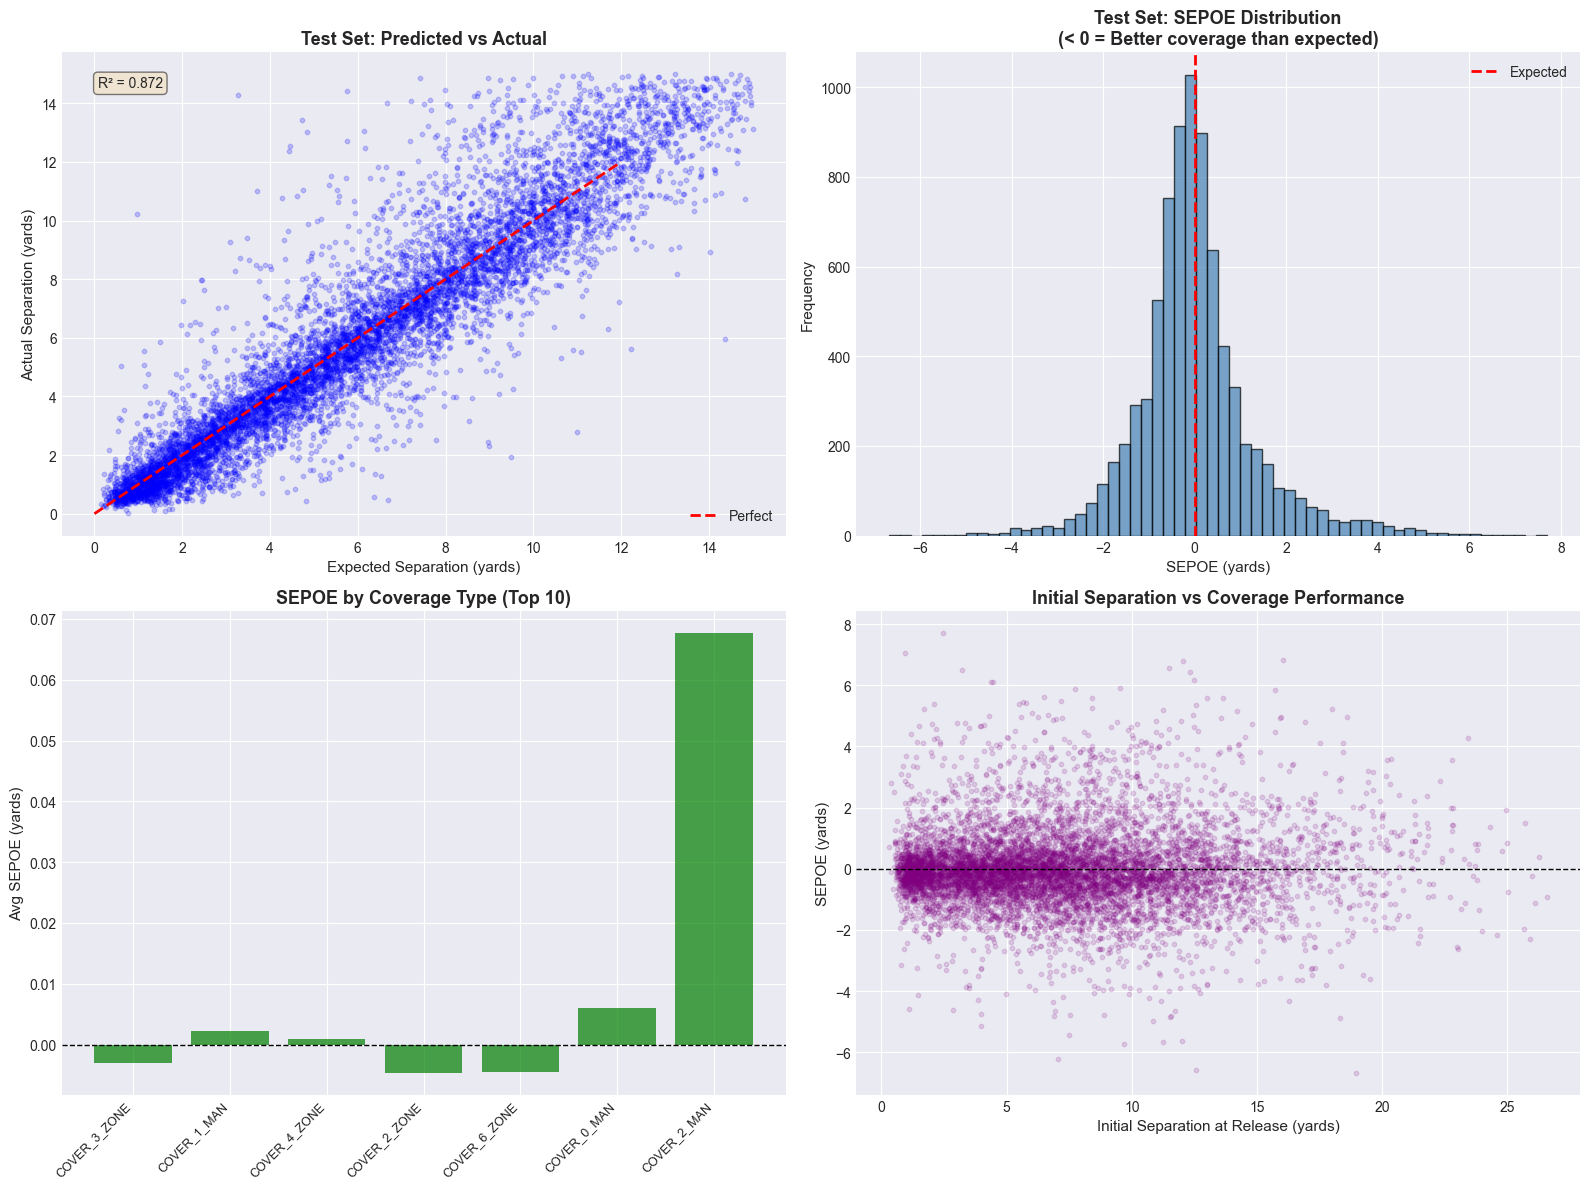

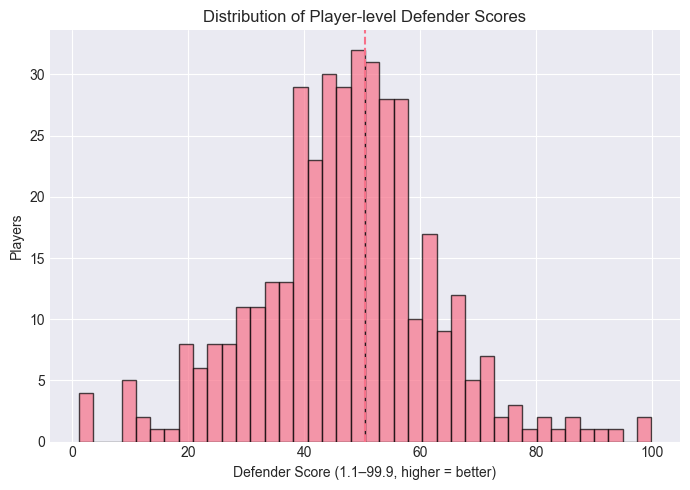

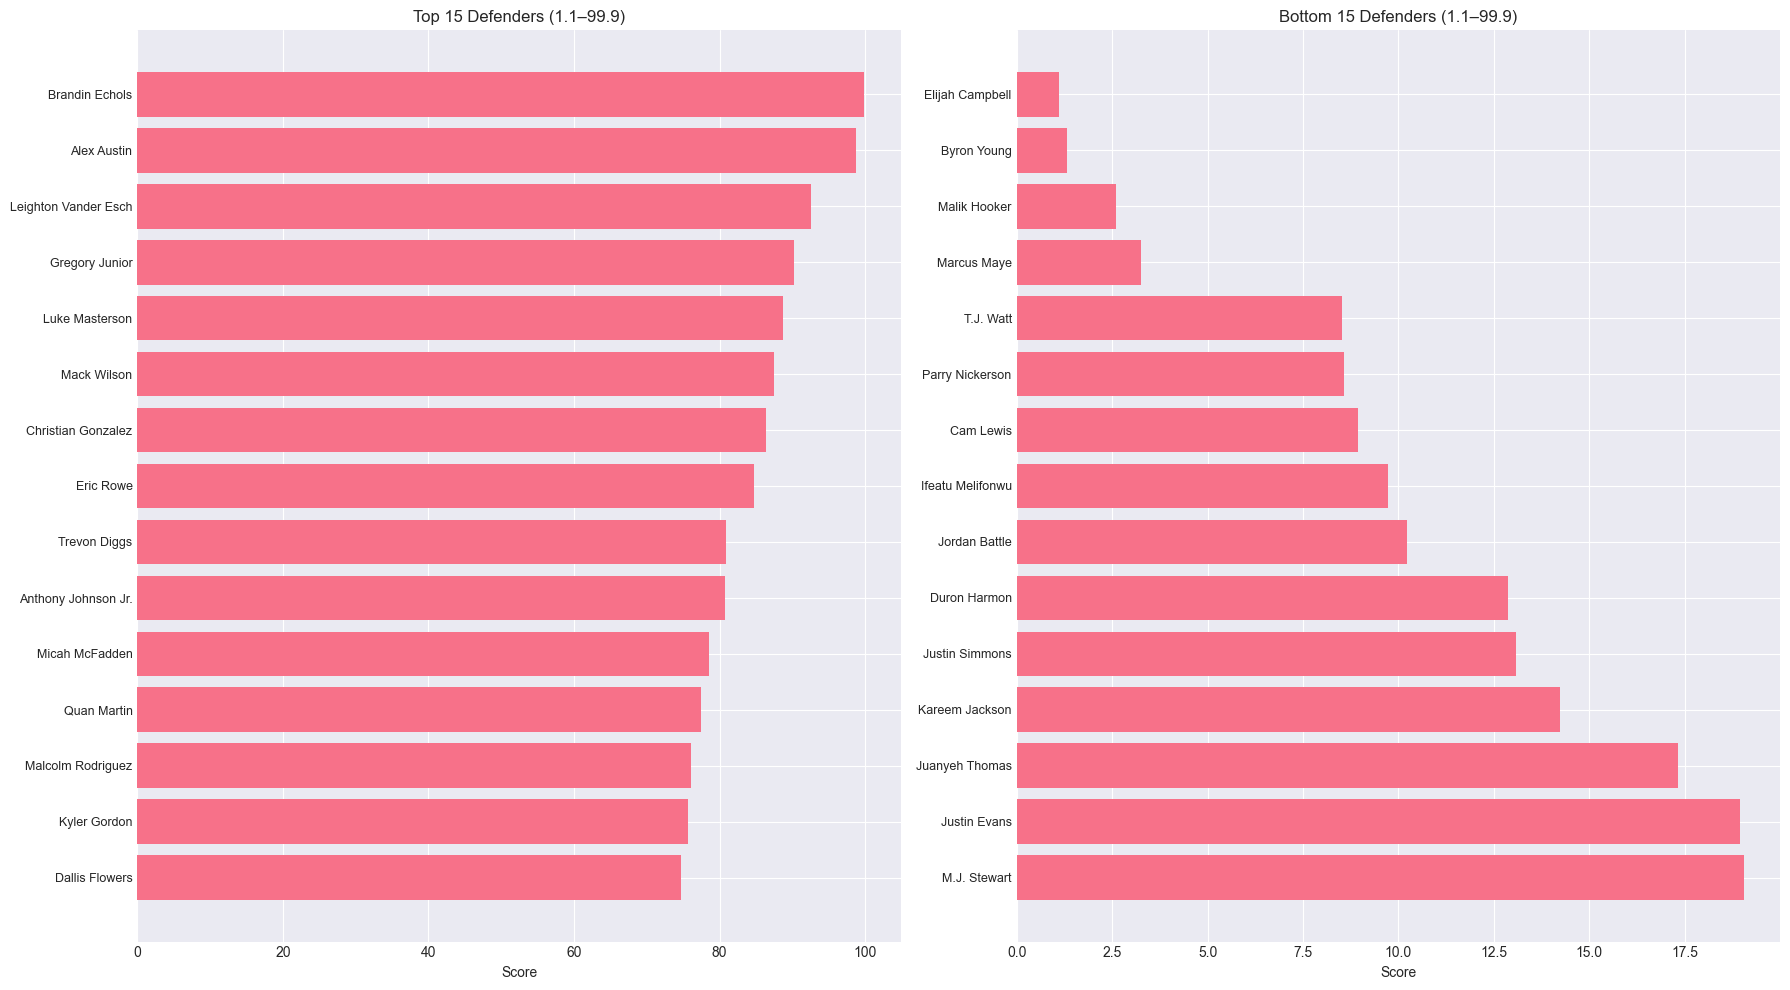


DEFENDER-FOCUSED SEPOE - FINAL REPORT

DATASET:
  Total defender-receiver pairs: 29,056
  Unique defenders: 705
  Unique receivers: 451

MODEL:
  Algorithm: HistGradientBoostingRegressor
  Features: 6 categorical + 9 angles + 21 numeric
  Total features after preprocessing: 45

PERFORMANCE (Time-based split):
  Test R²: 0.8718
  Test MAE: 0.914 yards
  Test RMSE: 1.383 yards

SEPOE DISTRIBUTION:
  Mean: 0.000 yards
  Median: -0.105 yards
  Std: 1.222 yards
  % Better than expected: 56.0%
DEFENDER LEADERBOARDS (Player-level 1.1–99.9)

Qualified defenders (min 15 targets): 397

Top 15 (by 1.1–99.9 score):
        defenderName  defenderId  targets  sepoe_mean  score_minmax_0_100_disp
      Brandin Echols       53629       22   -0.748946                     99.9
         Alex Austin       56117       24   -0.732115                     98.7
Leighton Vander Esch       46088       24   -0.646269                     92.6
      Gregory Junior       54662       16   -0.614256                   

In [27]:
print(f"\nSEPOE Summary:")
print(df["sepoe_def"].describe())
print(f"\n% Better than expected (SEPOE < 0): {(df['sepoe_def'] < 0).mean()*100:.1f}%")
print(f"% Worse than expected (SEPOE > 0): {(df['sepoe_def'] > 0).mean()*100:.1f}%")

df.to_csv("defender_rows_with_sepoe.csv", index=False)
print("\n✓ Saved: defender_rows_with_sepoe.csv")

print("\n" + "="*70)
print("DEFENDER LEADERBOARDS")
print("="*70)
MIN_TARGETS = 15
MIN_TARGETS_DEF = 15 

defender_avg = (
    df.groupby("defenderId", as_index=False)
      .agg(
          defenderName=("defenderName","first"),
          targets=("sepoe_def","size"),
          sepoe_mean=("sepoe_def","mean")
      )
)


defender_avg_qual = defender_avg[defender_avg["targets"] >= MIN_TARGETS_DEF].copy()


defender_avg_qual["rank_basis"] = -defender_avg_qual["sepoe_mean"]

# Min-max scale to [1.1, 99.9]
lo = float(defender_avg_qual["rank_basis"].min())
hi = float(defender_avg_qual["rank_basis"].max())
span = max(hi - lo, 1e-12)  # guard against zero span

def _scale(v):
    return 1.1 + (v - lo) * (99.9 - 1.1) / span

defender_avg_qual["score_minmax_0_100"] = defender_avg_qual["rank_basis"].map(_scale)

idx_lo = defender_avg_qual["rank_basis"].idxmin()
idx_hi = defender_avg_qual["rank_basis"].idxmax()
defender_avg_qual.loc[idx_lo, "score_minmax_0_100"] = 1.1
defender_avg_qual.loc[idx_hi, "score_minmax_0_100"] = 99.9

defender_avg_qual["score_minmax_0_100_disp"] = defender_avg_qual["score_minmax_0_100"].round(1)

defender_lb = (
    defender_avg_qual
      .sort_values("score_minmax_0_100", ascending=False)
      .reset_index(drop=True)
)
defender_lb.to_csv("defender_leaderboard_minmax_0_100.csv", index=False)

print("\n=== TOP 15 DEFENDERS (Best=99.9, Worst=1.1) ===")
print(defender_lb[["defenderName","defenderId","targets","sepoe_mean","score_minmax_0_100_disp"]].head(15).to_string(index=False))
print("\n=== BOTTOM 15 DEFENDERS ===")
print(defender_lb[["defenderName","defenderId","targets","sepoe_mean","score_minmax_0_100_disp"]].tail(15).to_string(index=False))


# Coverage-specific analysis
print("\n=== SEPOE by Coverage Type ===")

cov_lb = (df.groupby(["coverage_man_zone", "coverage_type"])
    .agg(
        sepoe_mean=("sepoe_def", "mean"),
        count=("sepoe_def", "size")
    )
    .reset_index()
    .sort_values("count", ascending=False))

print(cov_lb.head(15).to_string(index=False))
cov_lb.to_csv("sepoe_by_coverage.csv", index=False)


# Situational analysis
print("\n=== SEPOE by Down & Distance ===")

df["ytg_bin"] = pd.cut(
    df["yards_to_go"],
    bins=[0, 3, 7, 10, 15, 100],
    labels=["≤3", "4-7", "8-10", "11-15", "15+"]
)

sit_lb = (df.groupby(["down", "ytg_bin"])
    .agg(
        sepoe_mean=("sepoe_def", "mean"),
        count=("sepoe_def", "size")
    )
    .reset_index()
    .sort_values(["down", "ytg_bin"]))

print(sit_lb.head(20).to_string(index=False))
sit_lb.to_csv("sepoe_by_situation.csv", index=False)


# Receiver view (which receivers create most separation over expected)
print("\n=== RECEIVERS Creating Most Separation Over Expected ===")

MIN_REC_TARGETS = 15

rec_lb = (
    df.groupby("receiverId", as_index=False)
      .agg(
          receiverName=("receiverName", "first"),
          sepoe_mean=("sepoe_def", "mean"),
          sepoe_std=("sepoe_def", "std"),
          targets=("sepoe_def", "size")
      )
)

rec_lb_qual = rec_lb[rec_lb["targets"] >= MIN_REC_TARGETS].copy()
rec_lb_qual = rec_lb_qual.sort_values("sepoe_mean", ascending=False)


print(f"\n(High SEPOE = creates more separation than defenders expected)\n")
print(rec_lb_qual[["receiverName","receiverId","sepoe_mean","sepoe_std","targets"]].head(15).to_string(index=False))
rec_lb_qual.to_csv("receiver_leaderboard_sepoe.csv", index=False)
print("\n✓ Saved: receiver_leaderboard_sepoe.csv")

# Visualizations

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Predicted vs Actual (Test set)
axes[0, 0].scatter(
    df.loc[test_idx, "expected_sep_arrival_def"],
    df.loc[test_idx, "sep_arrival_def"],
    alpha=0.2, s=10, color='blue'
)
axes[0, 0].plot([0, 12], [0, 12], 'r--', linewidth=2, label='Perfect')
axes[0, 0].set_xlabel('Expected Separation (yards)', fontsize=11)
axes[0, 0].set_ylabel('Actual Separation (yards)', fontsize=11)
axes[0, 0].set_title('Test Set: Predicted vs Actual', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].text(0.05, 0.95, f'R² = {test_r2:.3f}',
                transform=axes[0, 0].transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


# SEPOE distribution (Test set)
axes[0, 1].hist(df.loc[test_idx, "sepoe_def"], bins=60, 
                edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Expected')
axes[0, 1].set_xlabel('SEPOE (yards)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Test Set: SEPOE Distribution\n(< 0 = Better coverage than expected)', 
                     fontsize=13, fontweight='bold')
axes[0, 1].legend()

# SEPOE by coverage type
top_cov = (df.groupby("coverage_type")["sepoe_def"]
    .agg(["mean", "count"])
    .sort_values("count", ascending=False)
    .head(10))

axes[1, 0].bar(range(len(top_cov)), top_cov["mean"], color='green', alpha=0.7)
axes[1, 0].set_xticks(range(len(top_cov)))
axes[1, 0].set_xticklabels(top_cov.index, rotation=45, ha='right', fontsize=9)
axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_ylabel('Avg SEPOE (yards)', fontsize=11)
axes[1, 0].set_title('SEPOE by Coverage Type (Top 10)', fontsize=13, fontweight='bold')

# SEPOE vs initial separation at release
axes[1, 1].scatter(
    df.loc[test_idx, "sep_release_def"],
    df.loc[test_idx, "sepoe_def"],
    alpha=0.15, s=10, color='purple'
)
axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Initial Separation at Release (yards)', fontsize=11)
axes[1, 1].set_ylabel('SEPOE (yards)', fontsize=11)
axes[1, 1].set_title('Initial Separation vs Coverage Performance', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig("defender_sepoe_overview.png", dpi=300, bbox_inches='tight')
print("✓ Saved: defender_sepoe_overview.png")
plt.show()

# 2) Score distribution (Test set)  <<< changed to score
plt.figure(figsize=(7,5))
plt.hist(defender_lb["score_minmax_0_100"], bins=40, edgecolor="black", alpha=0.7)
plt.axvline(50.5, linestyle="--")  # midpoint of 1.1..99.9 is ~50.5
plt.xlabel("Defender Score (1.1–99.9, higher = better)")
plt.ylabel("Players")
plt.title("Distribution of Player-level Defender Scores")
plt.tight_layout()
plt.savefig("defender_scores_playerlevel_hist.png", dpi=300)
plt.show()


# Defender leaderboard visualization
# Top 15 defenders
top15 = defender_lb.head(15).copy().sort_values("score_minmax_0_100", ascending=True)
bot15 = defender_lb.tail(15).copy().sort_values("score_minmax_0_100", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
axes[0].barh(np.arange(len(top15)), top15["score_minmax_0_100"])
axes[0].set_yticks(np.arange(len(top15)))
axes[0].set_yticklabels(top15["defenderName"], fontsize=9)
axes[0].set_title("Top 15 Defenders (1.1–99.9)")
axes[0].set_xlabel("Score")

axes[1].barh(np.arange(len(bot15)), bot15["score_minmax_0_100"])
axes[1].set_yticks(np.arange(len(bot15)))
axes[1].set_yticklabels(bot15["defenderName"], fontsize=9)
axes[1].set_title("Bottom 15 Defenders (1.1–99.9)")
axes[1].set_xlabel("Score")

plt.tight_layout()
plt.savefig("defender_leaderboards_minmax.png", dpi=300)
plt.show()

print("\n" + "="*70)
print("DEFENDER-FOCUSED SEPOE - FINAL REPORT")
print("="*70)

print(f"\nDATASET:")
print(f"  Total defender-receiver pairs: {len(df):,}")
print(f"  Unique defenders: {df['defenderId'].nunique()}")
print(f"  Unique receivers: {df['receiverId'].nunique()}")

print(f"\nMODEL:")
print(f"  Algorithm: HistGradientBoostingRegressor")
print(f"  Features: {len(categorical_features)} categorical + {len(angle_cols)} angles + {len(numeric_features)} numeric")
feat_cols = pre_only.transform(X_train.iloc[:1]).columns
print(f"  Total features after preprocessing: {len(feat_cols)}")

print(f"\nPERFORMANCE (Time-based split):")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Test MAE: {test_mae:.3f} yards")
print(f"  Test RMSE: {test_rmse:.3f} yards")

print(f"\nSEPOE DISTRIBUTION:")
print(f"  Mean: {df['sepoe_def'].mean():.3f} yards")
print(f"  Median: {df['sepoe_def'].median():.3f} yards")
print(f"  Std: {df['sepoe_def'].std():.3f} yards")
print(f"  % Better than expected: {(df['sepoe_def'] < 0).mean()*100:.1f}%")

print("DEFENDER LEADERBOARDS (Player-level 1.1–99.9)")
print("="*70)

print(f"\nQualified defenders (min {MIN_TARGETS_DEF} targets): {len(defender_lb):,}")
print("\nTop 15 (by 1.1–99.9 score):")
print(defender_lb[["defenderName","defenderId","targets","sepoe_mean","score_minmax_0_100_disp"]].head(15).to_string(index=False))

print("\nBottom 15:")
print(defender_lb[["defenderName","defenderId","targets","sepoe_mean","score_minmax_0_100_disp"]].tail(15).to_string(index=False))

# %%

## Checking Residuals and for any Red Flags


Residuals by coverage_type (mean±, count):
                   mean  count
coverage_type                 
COVER_6_ZONE   0.002791   2767
COVER_2_ZONE   0.004369   3485
COVER_3_ZONE   0.004851   9229
COVER_4_ZONE   0.007572   4922
COVER_1_MAN    0.008916   6888
COVER_0_MAN    0.014726   1217
COVER_2_MAN    0.080515    548

Residuals by coverage_man_zone (mean±, count):
                       mean  count
coverage_man_zone                 
ZONE_COVERAGE      0.005146  20403
MAN_COVERAGE       0.014268   8653

Residuals by route (mean±, count):
            mean  count
route                  
SLANT  -0.087187   2397
IN     -0.054574   3260
CROSS  -0.043161   2975
OUT    -0.025318   4291
SCREEN -0.015269    265
HITCH   0.004533   5870
FLAT    0.013237   2119
ANGLE   0.027533    609
POST    0.045510   2498
CORNER  0.070026   1369
GO      0.169104   3403

Residuals by down_cat (mean±, count):
              mean  count
down_cat                 
D2       -0.013738   9591
D4        0.009348    84

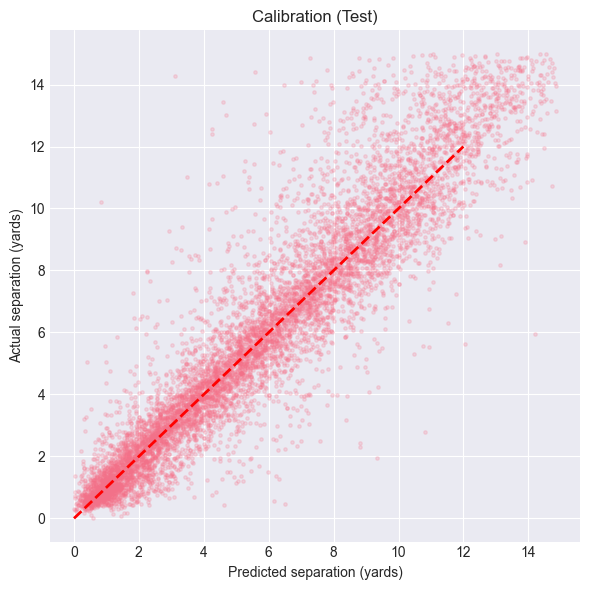

In [28]:
df["_pred"] = predict_ensemble(X_all)
df["_resid"] = df["sep_arrival_def"] - df["expected_sep_arrival_def"]

# Residuals by key drivers
for col in ["coverage_type","coverage_man_zone","route","down_cat", "ytg_bin"]:
    tmp = df.groupby(col)["_resid"].agg(["mean","count"]).sort_values("mean")
    print(f"\nResiduals by {col} (mean±, count):")
    print(tmp.head(15))

# Calibration
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(df.loc[test_idx,"_pred"], df.loc[test_idx,"sep_arrival_def"], s=6, alpha=0.2)
ax.plot([0,12],[0,12],"r--",lw=2)
ax.set_xlabel("Predicted separation (yards)")
ax.set_ylabel("Actual separation (yards)")
ax.set_title("Calibration (Test)")
plt.tight_layout(); plt.savefig("eda_calibration_test.png", dpi=160); plt.show()


In [17]:
df.head()

,game_id,play_id,week,receiverId,defenderId,passResult,route,coverage_man_zone,coverage_type,down,yards_to_go,yardline_number,dropback_distance,pass_location_type,time_in_air,ball_land_x,ball_land_y,rec_to_ball_dist,rec_x_release,rec_y_release,rec_speed_release,rec_accel_release,rec_dir_release,rec_o_release,receiverName,defenderName,def_x_release,def_y_release,def_speed_release,def_accel_release,def_dir_release,def_o_release,def_to_rec_dist_release,def_to_ball_dist_release,def_to_rec_angle,def_to_ball_angle,def_turn_to_rec,def_turn_to_ball,def_closing_speed_to_rec,def_closing_speed_to_ball,rec_toward_def_speed,rec_to_ball_angle,global_min_sep_at_release,sep_arrival_def,sep_release_def,down_cat,ytg_bin,is_man,receiverPositionRaw,defenderPositionRaw,receiverGroup,defenderGroup,route_squash,receiverId_key,rows_in_play,sample_weight,expected_sep_arrival_def,sepoe_def_raw,sepoe_def,_pred,_resid
0,2023090700,3461,1,44930,54495,C,IN,ZONE_COVERAGE,COVER_2_ZONE,3.0,12.0,23.0,5.30,INSIDE_BOX,1.3,49.27,34.32,6.124909,47.080002,40.040001,5.93,5.60,99.459999,127.459999,Josh Reynolds,George Karlaftis,41.299999,30.600000,5.64,2.30,102.570000,183.440002,11.068968,8.795414,58.521343,25.020820,124.918662,158.419182,4.053748,1.215993,-4.479591,-69.049810,3.373556,5.278732,11.068968,D3,11-15,0,WR,DE,WR,DL,IN,R44930,3,0.333333,4.885093,0.393639,0.393403,4.764925,0.393639
1,2023090700,3461,1,44930,54600,C,IN,ZONE_COVERAGE,COVER_2_ZONE,3.0,12.0,23.0,5.30,INSIDE_BOX,1.3,49.27,34.32,6.124909,47.080002,40.040001,5.93,5.60,99.459999,127.459999,Josh Reynolds,Joshua Williams,50.049999,41.639999,4.52,3.32,96.059998,197.369995,3.373556,7.361440,-151.687730,-96.082320,-10.942281,-66.547685,-1.711657,-4.418879,1.916155,-69.049810,3.373556,3.096837,3.373556,D3,11-15,0,WR,CB,WR,CB,IN,R44930,3,0.333333,2.668662,0.428175,0.427872,2.548494,0.428175
2,2023090700,3461,1,44930,54486,C,IN,ZONE_COVERAGE,COVER_2_ZONE,3.0,12.0,23.0,5.30,INSIDE_BOX,1.3,49.27,34.32,6.124909,47.080002,40.040001,5.93,5.60,99.459999,127.459999,Josh Reynolds,Trent McDuffie,42.369999,35.560001,2.82,3.83,74.190002,220.419998,6.500348,7.010537,43.566322,-10.187898,176.853678,-129.392104,2.426699,0.276266,-3.325131,-69.049810,3.373556,6.380362,6.500348,D3,11-15,0,WR,CB,WR,CB,IN,R44930,3,0.333333,4.221277,2.159085,2.120962,4.101110,2.159085
3,2023090700,461,1,44930,54527,C,POST,ZONE_COVERAGE,COVER_6_ZONE,1.0,10.0,34.0,4.72,INSIDE_BOX,1.0,55.91,18.83,6.344337,51.820000,13.980000,6.17,5.98,80.199997,46.270000,Josh Reynolds,Bryan Cook,62.130001,28.340000,5.20,0.98,156.490005,219.139999,17.677832,11.363473,-125.677070,-123.186620,-15.182935,-17.673373,1.095969,0.874055,5.551349,49.859097,3.877422,8.754617,17.677832,D1,8-10,0,WR,FS,WR,S/S/FS,POST,R44930,5,0.200000,9.539060,-0.784443,-0.782580,9.366818,-0.784443
4,2023090700,461,1,44930,46137,C,POST,ZONE_COVERAGE,COVER_6_ZONE,1.0,10.0,34.0,4.72,INSIDE_BOX,1.0,55.91,18.83,6.344337,51.820000,13.980000,6.17,5.98,80.199997,46.270000,Josh Reynolds,Justin Reid,58.549999,17.049999,4.04,2.04,113.050003,263.450012,7.397148,3.184022,-155.479110,146.010470,58.929119,117.439542,-0.103702,3.389747,3.478813,49.859097,3.877422,3.610679,7.397148,D1,8-10,0,WR,SS,WR,S/S/FS,POST,R44930,5,0.200000,5.643832,-2.033153,-2.001243,5.471591,-2.033153


## The Dalton Kincaid Example

In [29]:
GID = 2023091701
PID = 1938
TARGET_DEF = 47974     # Marcus Epps
TARGET_REC = 55889     # Dalton Kincaid


cols = [
    "season","week","defensive_team","possession_team",
    "quarter","game_clock","down","yards_to_go",
    "yardline_side","yardline_number","pass_result",
    "offense_formation","receiver_alignment","route_of_targeted_receiver",
    "team_coverage_man_zone","team_coverage_type","yards_gained"
]
row = supp_df.loc[(supp_df.game_id==GID) & (supp_df.play_id==PID), cols]
assert len(row)==1, f"Expected 1 supplementary row, got {len(row)}"
info = row.squeeze()

wk = int(info.week)
pin  = load_input_week(wk, use_cache=True)
pout = load_output_week(wk, use_cache=True)

rows = extract_defender_rows_for_play(
    int(GID), int(PID),
    pin, pout, info,
    arrival_radius=20.0
)
assert len(rows) > 0, "No defender rows found within 20 yards at arrival."

play_df = pd.DataFrame(rows)


X_cols = list(X_train.columns) if 'X_train' in globals() else None
X_play = play_df if X_cols is None else play_df.reindex(columns=X_cols, fill_value=0.0)

exp_sep = predict_ensemble(X_play)                   
act_sep = play_df["sep_arrival_def"].to_numpy()      
sepoe   = act_sep - exp_sep

play_df = play_df.assign(
    expected_sep = exp_sep.astype(float),
    actual_sep   = act_sep.astype(float),
    sepoe        = sepoe.astype(float)
)

one = play_df[(play_df["defenderId"]==TARGET_DEF) & (play_df["receiverId"]==TARGET_REC)]
assert len(one) >= 1, "Target defender/receiver pair not found in this play."
one = one.iloc[0]

print(
    f"Season {int(info.season)}, Week {wk}\n"
    f"{info.possession_team} (off) vs {info.defensive_team} (def)\n"
    f"Q{int(info.quarter)} @ {info.game_clock} | "
    f"{int(info.down)} & {int(info.yards_to_go)} on {info.yardline_side} {int(info.yardline_number)}\n"
    f"Result: {info.pass_result} | Yds gained: {int(info.yards_gained) if not pd.isna(info.yards_gained) else 'NA'}\n"
    f"Formation: {info.offense_formation} | Receiver align: {info.receiver_alignment} | "
    f"Route: {info.route_of_targeted_receiver}\n"
    f"Coverage: {info.team_coverage_man_zone} / {info.team_coverage_type}"
)

print(
    f"Defender: {one['defenderName']} (nfl_id={int(one['defenderId'])})\n"
    f"Receiver: {one['receiverName']} (nfl_id={int(one['receiverId'])})\n"
    f"Time in air: {one['time_in_air']:.2f}s\n"
    f"Actual separation @ arrival:  {one['actual_sep']:.3f} yds\n"
    f"Expected separation (model):  {one['expected_sep']:.3f} yds\n"
    f"SEPOE (actual - expected):    {one['sepoe']:.3f} yds"
)

print("\nAll defenders for this play (by SEPOE ascending):")
cols_show = ["defenderName","defenderId","receiverName","receiverId","actual_sep","expected_sep","sepoe"]
print(play_df.sort_values("sepoe").loc[:, cols_show].to_string(index=False))


Season 2023, Week 2
BUF (off) vs LV (def)
Q2 @ 00:28 | 1 & 10 on LV 11
Result: I | Yds gained: 0
Formation: SHOTGUN | Receiver align: 2x2 | Route: POST
Coverage: MAN_COVERAGE / COVER_1_MAN
Defender: Marcus Epps (nfl_id=47974)
Receiver: Dalton Kincaid (nfl_id=55889)
Time in air: 1.00s
Actual separation @ arrival:  2.554 yds
Expected separation (model):  6.005 yds
SEPOE (actual - expected):    -3.451 yds

All defenders for this play (by SEPOE ascending):
   defenderName  defenderId   receiverName  receiverId  actual_sep  expected_sep     sepoe
    Marcus Epps       47974 Dalton Kincaid       55889    2.553839      6.004602 -3.450763
  Marcus Peters       42361 Dalton Kincaid       55889    7.005427      8.450083 -1.444656
  Divine Deablo       53509 Dalton Kincaid       55889    7.688773      7.658620  0.030153
Tre'von Moehrig       53472 Dalton Kincaid       55889    0.619843      0.314177  0.305666


In [ ]:
#nspect values in the raw player_position column across all input weeks
vals = []
for w in WEEKS_TO_PROCESS:
    pin = load_input_week(w, use_cache=True)[["player_position"]]
    vals.append(pin["player_position"].astype(str).str.strip())

pos_counts = pd.concat(vals).value_counts()
print("\nplayer_position value counts across all weeks:")
print(pos_counts.to_string())

print("\nUnique values:")
print(sorted(pos_counts.index.unique()))



player_position value counts across all weeks:
player_position
WR     1063660
CB     1056888
FS      476865
TE      417146
QB      401007
SS      392421
RB      314918
ILB     295593
OLB     207429
MLB     199983
FB       19584
DE       16932
S        13764
DT        3139
NT        1090
T           83
LB          31
P           23
K           23

Unique values:
['CB', 'DE', 'DT', 'FB', 'FS', 'ILB', 'K', 'LB', 'MLB', 'NT', 'OLB', 'P', 'QB', 'RB', 'S', 'SS', 'T', 'TE', 'WR']


## Leaderboards

In [ ]:
OUT_DIR = "leaderboards_by_group"
os.makedirs(OUT_DIR, exist_ok=True)

def _most_common(series):
    if series.empty:
        return None
    c = Counter(series.dropna().astype(str))
    return c.most_common(1)[0][0]

def build_position_maps(weeks):
    """Return two dicts: {receiverId -> raw_position}, {defenderId -> raw_position} using input_* files."""
    frames = []
    for w in weeks:
        pin = load_input_week(w, use_cache=True)[
            ["nfl_id","player_side","player_role","player_position"]
        ].copy()
        frames.append(pin)
    big = pd.concat(frames, ignore_index=True)

    for c in ["player_side","player_role","player_position"]:
        big[c] = big[c].astype(str).str.strip().str.upper()

    rec_pos_map = (
        big.loc[(big["player_side"]=="OFFENSE") & (big["player_role"]=="TARGETED RECEIVER")]
           .groupby("nfl_id")["player_position"].agg(_most_common).to_dict()
    )

    def_pos_map = (
        big.loc[big["player_side"]=="DEFENSE"]
           .groupby("nfl_id")["player_position"].agg(_most_common).to_dict()
    )
    return rec_pos_map, def_pos_map

# Build/attach raw positions
weeks_src = sorted(train_weeks) if "train_weeks" in locals() else WEEKS_TO_PROCESS
rec_pos_map, def_pos_map = build_position_maps(weeks_src)
df["receiverPositionRaw"] = df["receiverId"].map(rec_pos_map).fillna("UNK").astype(str).str.upper()
df["defenderPositionRaw"] = df["defenderId"].map(def_pos_map).fillna("UNK").astype(str).str.upper()

def map_receiver_group(pos):
    p = (pos or "UNK").upper()
    if p == "WR": return "WR"
    if p in {"TE","FB"}: return "TE/FB"
    if p == "RB": return "RB"
    return "OTHER"

def map_defender_group(pos):
    p = (pos or "UNK").upper()
    if p == "CB": return "CB"
    if p in {"S","SS","FS"}: return "S/S/FS"
    if p in {"ILB","OLB","MLB","LB"}: return "LB"
    if p in {"DE","DT","NT"}: return "DL"
    return "OTHER"

df["receiverGroup"] = df["receiverPositionRaw"].map(map_receiver_group)
df["defenderGroup"] = df["defenderPositionRaw"].map(map_defender_group)

# Aggregation (player-level)

MIN_TARGETS_OFF = 15
MIN_TARGETS_DEF = 25

# Offense higher SEPOE is better
rec_lb = (
    df.groupby("receiverId", as_index=False)
      .agg(
          receiverName=("receiverName","first"),
          receiverPositionRaw=("receiverPositionRaw","first"),
          receiverGroup=("receiverGroup","first"),
          sepoe_mean=("sepoe_def","mean"),
          sepoe_std=("sepoe_def","std"),
          targets=("sepoe_def","size")
      )
)
rec_lb = rec_lb[rec_lb["targets"] >= MIN_TARGETS_OFF].copy()
rec_lb["base_metric"] = rec_lb["sepoe_mean"]  

def_lb = (
    df.groupby("defenderId", as_index=False)
      .agg(
          defenderName=("defenderName","first"),
          defenderPositionRaw=("defenderPositionRaw","first"),
          defenderGroup=("defenderGroup","first"),
          sepoe_mean=("sepoe_def","mean"),
          sepoe_std=("sepoe_def","std"),
          targets=("sepoe_def","size")
      )
)
def_lb = def_lb[def_lb["targets"] >= MIN_TARGETS_DEF].copy()
def_lb["base_metric"] = -def_lb["sepoe_mean"]  

# Unified scaling across ALL players

def _scale_to_1_100(v, vmin, vmax):
    """Map v linearly to [1.1, 99.9]. Handles degenerate span safely."""
    lo, hi = 1.1, 99.9
    span = max(vmax - vmin, 1e-9)
    return lo + (v - vmin) * (hi - lo) / span

# Collect min/max over all players 
all_base = pd.concat([
    rec_lb["base_metric"].rename("metric"),
    def_lb["base_metric"].rename("metric")
], ignore_index=True)

if all_base.empty:
    raise ValueError("No qualified players found for unified scaling.")

vmin = float(all_base.min())
vmax = float(all_base.max())

# Apply unified scaling
rec_lb["score_1_100"] = _scale_to_1_100(rec_lb["base_metric"].to_numpy(), vmin, vmax)
def_lb["score_1_100"] = _scale_to_1_100(def_lb["base_metric"].to_numpy(), vmin, vmax)


# Printing & plotting utils

def _print_block(title, frame, sort_col, ascending, cols_show, n_top=15, n_bot=15):
    print(f"\n=== {title} (min targets={frame['targets'].min() if not frame.empty else 0}) ===")
    if frame.empty:
        print("  (no qualified players)")
        return
    order = frame.sort_values(sort_col, ascending=ascending)
    print("\n-- TOP --")
    print(order[cols_show].head(n_top).to_string(index=False))
    print("\n-- BOTTOM --")
    print(order[cols_show].tail(n_bot).to_string(index=False))

def _plot_block(fig_title, frame, name_col, val_col, sort_ascending, save_path,
                subtitle_top="Top", subtitle_bottom="Bottom",
                n_top=15, n_bot=15, xlabel="Value"):
    if frame.empty:
        print(f"[plot] {fig_title}: no qualified players, skipping.")
        return

    order = frame.sort_values(val_col, ascending=sort_ascending)
    top = order.head(n_top)[[name_col, val_col, "targets"]].copy()
    bot = order.tail(n_bot)[[name_col, val_col, "targets"]].copy()

    plt.figure(figsize=(16, 10))
    plt.suptitle(fig_title, fontsize=16, fontweight="bold")

    # TOP
    ax1 = plt.subplot(1, 2, 1)
    y_pos = np.arange(len(top))[::-1]
    ax1.barh(y_pos, top[val_col].values)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([f"{n}  (t={t})" for n, t in zip(top[name_col], top["targets"])], fontsize=9)
    ax1.axvline(0, color='k', lw=1)
    ax1.set_xlabel(xlabel)
    ax1.set_title(subtitle_top)

    # BOTTOM
    ax2 = plt.subplot(1, 2, 2)
    y_pos2 = np.arange(len(bot))[::-1]
    ax2.barh(y_pos2, bot[val_col].values)
    ax2.set_yticks(y_pos2)
    ax2.set_yticklabels([f"{n}  (t={t})" for n, t in zip(bot[name_col], bot["targets"])], fontsize=9)
    ax2.axvline(0, color='k', lw=1)
    ax2.set_xlabel(xlabel)
    ax2.set_title(subtitle_bottom)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✓ Saved plot: {save_path}")

def _combined_grid(blocks, titles, name_col, val_col, sort_ascending, sup_title, save_path, xlabel):
    n = len(blocks)
    cols = 2
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(16, 7 * rows))
    plt.suptitle(sup_title, fontsize=16, fontweight="bold")

    for i, (frame, title) in enumerate(zip(blocks, titles), 1):
        ax = plt.subplot(rows, cols, i)
        if frame.empty:
            ax.set_title(f"{title}\n(no qualified players)")
            ax.axis("off")
            continue
        order = frame.sort_values(val_col, ascending=sort_ascending)
        top = order.head(12)[[name_col, val_col, "targets"]]
        y_pos = np.arange(len(top))[::-1]
        ax.barh(y_pos, top[val_col].values)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f"{n}  (t={t})" for n, t in zip(top[name_col], top["targets"])], fontsize=9)
        ax.axvline(0, color='k', lw=1)
        ax.set_xlabel(xlabel)
        ax.set_title(title + " — Top 12")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✓ Saved combined summary: {save_path}")


# OFFENSE (WR / TE+FB / RB)
offense_groups = [
    ("WR",   "OFFENSE - WIDE RECEIVERS"),
    ("TE/FB","OFFENSE - TIGHT ENDS (incl FB)"),
    ("RB",   "OFFENSE - RUNNING BACKS"),
]

off_top_rows, off_bot_rows = [], []

for g, nice in offense_groups:
    block = rec_lb[rec_lb["receiverGroup"] == g].copy()
    _print_block(
        f"{nice}: Unified score leaderboard (creates more sep than expected)",
        block,
        sort_col="score_1_100",
        ascending=False,  
        cols_show=["receiverName","receiverId","receiverGroup","receiverPositionRaw","targets","score_1_100","sepoe_mean","sepoe_std"],
        n_top=15, n_bot=15
    )

    save_png = os.path.join(OUT_DIR, f"offense_{g.replace('/','_')}_top_bottom_unified.png")
    _plot_block(
        fig_title=f"{nice} — Unified Score (1.1–99.9; higher = better offense)",
        frame=block,
        name_col="receiverName",
        val_col="score_1_100",
        sort_ascending=False,
        save_path=save_png,
        subtitle_top="Top (highest unified score)",
        subtitle_bottom="Bottom (lowest unified score)",
        n_top=15, n_bot=15,
        xlabel="Unified Score (1.1–99.9)"
    )

    if not block.empty:
        top_csv = block.sort_values("score_1_100", ascending=False).head(15).assign(group=g, rank_side="top")
        bot_csv = block.sort_values("score_1_100", ascending=False).tail(15).assign(group=g, rank_side="bottom")
        off_top_rows.append(top_csv)
        off_bot_rows.append(bot_csv)

if off_top_rows:
    pd.concat(off_top_rows, ignore_index=True).to_csv(os.path.join(OUT_DIR, "leaderboard_offense_by_group_top_unified.csv"), index=False)
    pd.concat(off_bot_rows, ignore_index=True).to_csv(os.path.join(OUT_DIR, "leaderboard_offense_by_group_bottom_unified.csv"), index=False)
    print("✓ Saved offense CSVs (top & bottom, unified scale) in", OUT_DIR)

# DEFENSE (CB / S/SS/FS / LB / DL)
defense_groups = [
    ("CB",     "DEFENSE - CORNERBACKS"),
    ("S/S/FS", "DEFENSE - SAFETIES (S/SS/FS)"),
    ("LB",     "DEFENSE - LINEBACKERS (ILB/OLB/MLB/LB)"),
    ("DL",     "DEFENSE - D-LINE (DE/DT/NT)"),
]

def_top_rows, def_bot_rows = [], []

for g, nice in defense_groups:
    block = def_lb[def_lb["defenderGroup"] == g].copy()
    _print_block(
        f"{nice}: Unified score leaderboard (better coverage → higher score)",
        block,
        sort_col="score_1_100",
        ascending=False,  # higher unified score = better defender
        cols_show=["defenderName","defenderId","defenderGroup","defenderPositionRaw","targets","score_1_100","sepoe_mean","sepoe_std"],
        n_top=15, n_bot=15
    )

    save_png = os.path.join(OUT_DIR, f"defense_{g.replace('/','_')}_top_bottom_unified.png")
    _plot_block(
        fig_title=f"{nice} — Unified Score (1.1–99.9; higher = better coverage)",
        frame=block,
        name_col="defenderName",
        val_col="score_1_100",
        sort_ascending=False,
        save_path=save_png,
        subtitle_top="Top (highest unified score)",
        subtitle_bottom="Bottom (lowest unified score)",
        n_top=15, n_bot=15,
        xlabel="Unified Score (1.1–99.9)"
    )

    if not block.empty:
        top_csv = block.sort_values("score_1_100", ascending=False).head(15).assign(group=g, rank_side="top")
        bot_csv = block.sort_values("score_1_100", ascending=False).tail(15).assign(group=g, rank_side="bottom")
        def_top_rows.append(top_csv)
        def_bot_rows.append(bot_csv)

if def_top_rows:
    pd.concat(def_top_rows, ignore_index=True).to_csv(os.path.join(OUT_DIR, "leaderboard_defense_by_group_top_unified.csv"), index=False)
    pd.concat(def_bot_rows, ignore_index=True).to_csv(os.path.join(OUT_DIR, "leaderboard_defense_by_group_bottom_unified.csv"), index=False)
    print("✓ Saved defense CSVs (top & bottom, unified scale) in", OUT_DIR)

# Combined summary figures

_combined_grid(
    blocks=[rec_lb[rec_lb["receiverGroup"] == g] for g, _ in offense_groups],
    titles=[nice for _, nice in offense_groups],
    name_col="receiverName",
    val_col="score_1_100",
    sort_ascending=False,
    sup_title="OFFENSE — Unified Score (1.1–99.9): Top 12 per group",
    save_path=os.path.join(OUT_DIR, "offense_groups_top12_unified.png"),
    xlabel="Unified Score (1.1–99.9)"
)

_combined_grid(
    blocks=[def_lb[def_lb["defenderGroup"] == g] for g, _ in defense_groups],
    titles=[nice for _, nice in defense_groups],
    name_col="defenderName",
    val_col="score_1_100",
    sort_ascending=False,
    sup_title="DEFENSE — Unified Score (1.1–99.9): Top 12 per group",
    save_path=os.path.join(OUT_DIR, "defense_groups_top12_unified.png"),
    xlabel="Unified Score (1.1–99.9)"
)

print("\n✓ Finished leaderboards by group (UNIFIED 1.1–99.9 scale across offense & defense).")
print(f"Scale min/max were computed from all players: vmin={vmin:.4f}, vmax={vmax:.4f} (after O=higher, D=−SEPOE).")



=== OFFENSE - WIDE RECEIVERS: Unified score leaderboard (creates more sep than expected) (min targets=15) ===

-- TOP --
        receiverName  receiverId receiverGroup receiverPositionRaw  targets  score_1_100  sepoe_mean  sepoe_std
      Mecole Hardman       47839            WR                  WR       21    99.899849    0.575751   1.510331
       Robbie Chosen       43808            WR                  WR       18    93.513023    0.490349   1.283280
          Tre Tucker       55965            WR                  WR       62    93.330757    0.487911   1.510564
        Scott Miller       47991            WR                  WR       24    93.274124    0.487154   1.665147
     Marvin Mims Jr.       55928            WR                  WR       38    88.808350    0.427439   1.991760
        Deonte Harty       48415            WR                  WR       19    88.534821    0.423781   1.294889
           Zay Jones       44849            WR                  WR      119    83.980545    0.

In [ ]:
# Save FULL leaderboards
groups_to_save = {
    "safeties":   "S/S/FS",
    "corners":    "CB",
    "linebackers":"LB",
}

for label, grp_code in groups_to_save.items():
    block = def_lb.loc[def_lb["defenderGroup"] == grp_code].copy()
    if block.empty:
        print(f"[skip] No qualified {label} in {grp_code}.")
        continue

    block = block.sort_values("score_1_100", ascending=False)
    block["score_1_100"] = block["score_1_100"].round(2)
    block["sepoe_mean"]  = block["sepoe_mean"].round(4)
    block["sepoe_std"]   = block["sepoe_std"].round(4)

    cols = [
        "defenderName","defenderId","defenderPositionRaw","defenderGroup",
        "targets","score_1_100","sepoe_mean","sepoe_std"
    ]
    out_path = os.path.join(OUT_DIR, f"leaderboard_{label}_FULL_unified.csv")
    block[cols].to_csv(out_path, index=False)
    print(f"✓ Saved {label.title()} full leaderboard → {out_path}")


✓ Saved Safeties full leaderboard → leaderboards_by_group\leaderboard_safeties_FULL_unified.csv
✓ Saved Corners full leaderboard → leaderboards_by_group\leaderboard_corners_FULL_unified.csv
✓ Saved Linebackers full leaderboard → leaderboards_by_group\leaderboard_linebackers_FULL_unified.csv


In [24]:
def week_metrics(df, y_col="sep_arrival_def", p_col="expected_sep_arrival_def", by="week", w_col=None):
    g = df.groupby(by)
    rows=[]
    for k, d in g:
        y = d[y_col].to_numpy()
        p = d[p_col].to_numpy()
        if w_col and w_col in d:
            w = d[w_col].to_numpy()
            mae = np.average(np.abs(y-p), weights=w)
            rmse = np.sqrt(np.average((y-p)**2, weights=w))
        else:
            mae = np.mean(np.abs(y-p))
            rmse = np.sqrt(np.mean((y-p)**2))
        rows.append({by:int(k), "n":len(d), "MAE":float(mae), "RMSE":float(rmse)})
    out = pd.DataFrame(rows).sort_values(by)
    print(out.to_string(index=False))
    return out

_ = week_metrics(df.loc[train_idx], p_col="expected_sep_arrival_def", by="week", w_col="sample_weight")
_ = week_metrics(df.loc[test_idx ], p_col="expected_sep_arrival_def", by="week", w_col="sample_weight")


 week    n      MAE     RMSE
    2 1752 0.687664 1.082565
    3 1890 0.718102 1.134851
    4 1611 0.711615 1.066785
    5 1562 0.701507 1.092345
    6 1650 0.733087 1.143108
    7 1466 0.685836 1.075057
    8 1702 0.745745 1.168564
    9 1420 0.689360 1.070816
   11 1473 0.684763 1.081565
   12 1673 0.693300 1.094771
   13 1425 0.741236 1.148350
   14 1610 0.687162 1.060296
   15 1643 0.690501 1.049212
   16 1848 0.970095 1.444730
   18 1468 0.940173 1.415959
 week    n      MAE     RMSE
    1 1718 0.937765 1.409030
    5 1562 0.701507 1.092345
   10 1480 0.903823 1.373010
   12 1673 0.693300 1.094771
   17 1665 0.910068 1.358311


In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

os.makedirs(OUT_DIR, exist_ok=True)
_p = lambda name: os.path.join(OUT_DIR, name)

def _annot(ax, txt, x=0.02, y=0.98):
    ax.text(x, y, txt, transform=ax.transAxes, va="top",
            bbox=dict(boxstyle="round", fc="white", ec="0.7", alpha=0.9),
            fontsize=10)

def _ensure_defender_group_on_def_lb(def_lb, df):
    """Make sure def_lb has a defenderGroup column; rebuild from df if missing."""
    if "defenderGroup" in def_lb.columns:
        return def_lb

    if "defenderGroup" in df.columns:
        grp_map = (
            df.groupby("defenderId")["defenderGroup"]
              .agg(lambda s: s.dropna().astype(str).value_counts().idxmax() if len(s.dropna()) else "OTHER")
              .to_dict()
        )
        def_lb = def_lb.copy()
        def_lb["defenderGroup"] = def_lb["defenderId"].map(grp_map).fillna("OTHER")
        return def_lb

    if "defenderPositionRaw" in def_lb.columns:
        def_lb = def_lb.copy()
        def_lb["defenderGroup"] = def_lb["defenderPositionRaw"].map(map_defender_group).fillna("OTHER")
        return def_lb

    if "defenderPositionRaw" in df.columns:
        pos_map = (
            df.groupby("defenderId")["defenderPositionRaw"]
              .agg(lambda s: s.dropna().astype(str).value_counts().idxmax() if len(s.dropna()) else "UNK")
              .to_dict()
        )
        def_lb = def_lb.copy()
        def_lb["defenderPositionRaw"] = def_lb["defenderId"].map(pos_map).fillna("UNK")
        def_lb["defenderGroup"] = def_lb["defenderPositionRaw"].map(map_defender_group).fillna("OTHER")
        return def_lb

    raise KeyError("Could not reconstruct defenderGroup on def_lb from available columns.")

def_lb = _ensure_defender_group_on_def_lb(def_lb, df)

fig, ax = plt.subplots(figsize=(6.5, 5.5))
x = df.loc[test_idx, "expected_sep_arrival_def"].to_numpy()
y = df.loc[test_idx, "sep_arrival_def"].to_numpy()
ax.scatter(x, y, s=8, alpha=0.25)
lo, hi = 0.0, max(12.0, float(np.nanpercentile(np.r_[x, y], 99)))
ax.plot([lo, hi], [lo, hi])
ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
ax.set_xlabel("Expected separation at arrival (yds)")
ax.set_ylabel("Actual separation at arrival (yds)")
ax.set_title("Test calibration: expected vs actual")
try:
    ax.text(0.98, 0.02, f"R² = {float(test_r2):.3f}", transform=ax.transAxes,
            ha="right", va="bottom")
except Exception:
    pass
fig.tight_layout(); fig.savefig(_p("fig01_calibration.png"), dpi=200); plt.close(fig)
print("✓ Saved", _p("fig01_calibration.png"))

fig, ax = plt.subplots(figsize=(6.5, 5.0))
vals = df.loc[test_idx, "sepoe_def"].to_numpy()
ax.hist(np.clip(vals, -8, 8), bins=60, edgecolor="black", alpha=0.8)
ax.axvline(0.0, linestyle="--", lw=1)
ax.set_xlabel("SEPOE (yds)  [negative = defender win]")
ax.set_ylabel("Count")
ax.set_title("SEPOE distribution (test)")
_annot(ax, f"n = {np.isfinite(vals).sum():,}")
fig.tight_layout(); fig.savefig(_p("fig02_sepoe_hist.png"), dpi=200); plt.close(fig)
print("✓ Saved", _p("fig02_sepoe_hist.png"))

cov = (df
       .groupby(["coverage_man_zone","coverage_type"], observed=True)
       .agg(sepoe_mean=("sepoe_def","mean"), t=("sepoe_def","size"))
       .reset_index())
cov = cov[cov["t"] >= 300].sort_values("sepoe_mean")
fig, ax = plt.subplots(figsize=(7.5, max(3.5, 0.3*len(cov))))
ax.barh(np.arange(len(cov)), cov["sepoe_mean"])
ax.set_yticks(np.arange(len(cov)))
ax.set_yticklabels([
    f"{r['coverage_man_zone'].split('_')[0].title()} — {r['coverage_type'].title()}  (t={int(r['t'])})"
    for _, r in cov.iterrows()
], fontsize=9)
ax.axvline(0.0, linestyle="--", lw=1)
ax.set_xlabel("Mean SEPOE (yds)  [lower = better defense; t = targets]")
ax.set_title("SEPOE by coverage type (n ≥ 300)")
fig.tight_layout(); fig.savefig(_p("fig03_coverage_bars.png"), dpi=200); plt.close(fig)
print("✓ Saved", _p("fig03_coverage_bars.png"))

cb_block = def_lb[def_lb["defenderGroup"] == "CB"].copy()
if cb_block.empty:
    print("[WARN] No qualified CBs for figure 4.")
else:
    cb_top = cb_block.sort_values("score_1_100", ascending=False).head(15)
    fig, ax = plt.subplots(figsize=(8.5, 6.5))
    y_pos = np.arange(len(cb_top))                     
    ax.barh(y_pos, cb_top["score_1_100"].values)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{n}  (t={t})" for n, t in zip(cb_top["defenderName"], cb_top["targets"])], fontsize=9)
    ax.set_xlabel("Unified Score (1.1–99.9)  [higher = tighter coverage; t = targets]")
    ax.set_title("Top 15 CORNERBACKS — SEPOE unified score")
    ax.invert_yaxis()                                  
    fig.tight_layout()
    fig.savefig(_p("fig04_corner_top.png"), dpi=200); plt.close(fig)
    print("✓ Saved", _p("fig04_corner_top.png"))

s_block = def_lb[def_lb["defenderGroup"] == "S/S/FS"].copy()
if s_block.empty:
    print("[WARN] No qualified S/SS/FS for figure 5.")
else:
    s_top = s_block.sort_values("score_1_100", ascending=False).head(15)
    fig, ax = plt.subplots(figsize=(8.5, 6.5))
    y_pos = np.arange(len(s_top))                      
    ax.barh(y_pos, s_top["score_1_100"].values)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{n}  (t={t})" for n, t in zip(s_top["defenderName"], s_top["targets"])], fontsize=9)
    ax.set_xlabel("Unified Score (1.1–99.9)  [higher = tighter coverage; t = targets]")
    ax.set_title("Top 15 SAFETIES — SEPOE unified score")
    ax.invert_yaxis()                                 
    fig.tight_layout()
    fig.savefig(_p("fig05_safety_top.png"), dpi=200); plt.close(fig)
    print("✓ Saved", _p("fig05_safety_top.png"))


if ("ytg_bin" not in df.columns) or df["ytg_bin"].isna().all():
    df["ytg_bin"] = pd.cut(
        df["yards_to_go"],
        bins=[0,3,7,10,15,100],
        labels=["≤3","4–7","8–10","11–15","15+"],
        include_lowest=True
    )
pivot = (df.groupby(["down","ytg_bin"], observed=True)
           .agg(sepoe_mean=("sepoe_def","mean"))
           .reset_index())
mat = pivot.pivot(index="down", columns="ytg_bin", values="sepoe_mean").sort_index()
fig, ax = plt.subplots(figsize=(7.5, 4.8))
im = ax.imshow(mat.values, aspect="auto")
ax.set_xticks(np.arange(mat.shape[1])); ax.set_xticklabels(mat.columns.astype(str))
ax.set_yticks(np.arange(mat.shape[0])); ax.set_yticklabels(mat.index.astype(int))
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        v = mat.values[i, j]
        if np.isfinite(v):
            ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=9, color="white")
ax.set_xlabel("Yards to go (bins)")
ax.set_ylabel("Down")
ax.set_title("Mean SEPOE by situation (defense; lower is better)")
fig.colorbar(im, ax=ax, shrink=0.9, label="Mean SEPOE (yds)")
fig.tight_layout(); fig.savefig(_p("fig06_situation_heatmap.png"), dpi=200); plt.close(fig)
print("✓ Saved", _p("fig06_situation_heatmap.png"))

print("\nSaved figures:",
      _p("fig01_calibration.png"), ",",
      _p("fig02_sepoe_hist.png"), ",",
      _p("fig03_coverage_bars.png"), ",",
      _p("fig04_corner_top.png"), ",",
      _p("fig05_safety_top.png"), ",",
      _p("fig06_situation_heatmap.png"))


✓ Saved leaderboards_by_group\fig01_calibration.png
✓ Saved leaderboards_by_group\fig02_sepoe_hist.png
✓ Saved leaderboards_by_group\fig03_coverage_bars.png
✓ Saved leaderboards_by_group\fig04_corner_top.png
✓ Saved leaderboards_by_group\fig05_safety_top.png
✓ Saved leaderboards_by_group\fig06_situation_heatmap.png

Saved figures: leaderboards_by_group\fig01_calibration.png , leaderboards_by_group\fig02_sepoe_hist.png , leaderboards_by_group\fig03_coverage_bars.png , leaderboards_by_group\fig04_corner_top.png , leaderboards_by_group\fig05_safety_top.png , leaderboards_by_group\fig06_situation_heatmap.png
